<a href="https://www.kaggle.com/code/ayodejiibrahimlateef/hotel-demand-forecasting-daily-weekly-hybrid?scriptVersionId=289163571" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This notebook delivers a production-ready demand forecasting pipeline for the Kaggle **Hotel Booking Demand** dataset (`/kaggle/input/hotel-booking-demand/hotel_bookings.csv`). The objective is to generate **reliable daily and weekly forecasts** across multiple operational and commercial demand signals while keeping the workflow robust to data issues, minimizing noise, and producing exportable artifacts that can be reused in downstream analytics or deployment contexts.

### Forecasting objectives

Hotels face strong seasonality (weekday/weekend, annual cycles), short-term volatility, and structural differences across segments. This notebook is designed to support practical planning use cases by producing forecasts at two levels:

- **Daily forecasts**: short-horizon operational planning (staffing, inventory, rate adjustments, workload planning).
- **Weekly forecasts**: medium-horizon planning (capacity planning, budgeting, procurement, strategic operations).

Each hotel type is modeled as a separate series (e.g., **City Hotel** and **Resort Hotel**) to avoid mixing series with different seasonal and volatility behaviors.

### Targets forecasted

From booking-level records, the notebook constructs forecastable time series at daily and weekly frequency, such as:

- **bookings**: total arrivals per day/week.
- **canceled_bookings**: cancellations per day/week.
- **net_bookings**: bookings adjusted for cancellations (as defined in the notebook).
- **guests_total / adults_total**: aggregated guest volume measures.
- **room_nights**: room-night demand implied by stays.
- **revenue**: a revenue proxy constructed from aggregated ADR and volume (as defined in the notebook).
- **adr_mean**: average daily rate signal.
- **cancel_rate**: cancellation ratio.

All targets are represented in a consistent **panel time series** format:

- `unique_id`: series identifier (hotel type)
- `ds`: timestamp
- `y`: target value

### Data preparation and noise reduction principles

Because the dataset is transactional and must be aggregated into time series, the notebook prioritizes data steps that preserve the true demand signal:

1. **Robust date construction**  
   A valid `arrival_date` is created from year/month/day fields using a safe month mapping. This becomes the canonical time index used for aggregation.

2. **Deterministic missing value handling**  
   - `children`: imputed with 0, clipped at 0, and converted to integer (count variable).
   - `country`: imputed with `"UNK"`.
   - `agent` / `company`: imputed with `-1` to preserve categorical identity safely.

3. **Duplicate handling aligned with demand aggregation**  
   Duplicate-looking rows are not automatically removed. Because the dataset represents booking transactions, repeated identical rows can be legitimate and contribute to true demand. The workflow preserves them unless a targeted investigation confirms they are erroneous duplicates.

4. **Stable aggregation rules**  
   Daily and weekly series are computed consistently per hotel type. Weekly series are anchored to a consistent definition (e.g., **W-MON**) so that each week is comparable for modeling and evaluation.

### Modeling approach: hybrid forecasting

To maximize accuracy and stability, the notebook uses a hybrid approach combining statistical time series models and machine learning:

#### Statistical models (StatsForecast)

- **ETS / AutoETS (or ETSModel depending on library version)**: trend + seasonality baselines.
- **AutoARIMA**: autocorrelation and seasonal structure.
- **Seasonal Naive** (when included): strong benchmark, frequently competitive for stable seasonal demand.

#### Machine learning model (MLForecast + LightGBM)

- **LightGBM regressor** trained on:
  - lag features (e.g., 1, 7, 14, 28, etc.)
  - calendar features (day-of-week, week-of-year/week index, month, year depending on frequency)
- Designed to capture nonlinearities and interactions that classical models may not represent explicitly.

#### Variance stabilization with log1p (ML side)

For spiky and heteroscedastic targets (counts and revenue-like series), the ML model can be trained on a stabilized scale:

- `y_ml = log1p(clip(y, 0))`
- predictions are back-transformed using `expm1` and clipped at 0

This reduces sensitivity to outliers and typically improves generalization while maintaining non-negativity constraints.

#### Hybrid blending

A **Hybrid** prediction is computed as a weighted blend:

- `Hybrid = alpha * base_stat + (1 - alpha) * LGBM`

Where:
- `alpha` is chosen via backtesting.
- `base_stat` is the selected statistical baseline (ETS or AutoARIMA), depending on what best supports each target/series.

### Validation and model selection (rolling backtests)

Forecast performance is assessed using **rolling-origin cross-validation** (walk-forward validation), which simulates real forecasting:

- Each window trains on historical data and predicts a fixed horizon.
- Multiple windows are evaluated to reduce dependence on a single cutoff.
- Best model selection is performed per **frequency × target × hotel series** using robust error metrics.

Evaluation focuses on accuracy and operational relevance:

- **MAE / RMSE**: magnitude of errors.
- **MAPE / sMAPE**: relative accuracy (with safe handling).
- **WAPE**: weighted error metric commonly preferred for demand.
- **Bias / Bias%**: systematic over/under forecasting.
- **Over/under forecasting rates**: directional diagnostics.
- **Actual vs forecast totals**: volume-level realism.

### Deliverables produced

At the end of the workflow, the notebook generates production-ready artifacts:

1. **Backtest outputs**
   - historical predictions for each model and “best model” selection
   - backtest CSVs for daily and weekly

2. **Future forecasts (2 years)**
   - all-model forecasts saved as CSV
   - best-model forecasts saved as CSV

3. **Visual artifacts**
   For each target and series:
   - actual + forecast plots (daily and weekly)
   - last-window backtest overlays
   - error distribution histograms

4. **Forecast statistics report**
   A detailed CSV summarizing performance and diagnostics suitable for reporting, monitoring, and stakeholder communication.


## Install packages

In [1]:
!pip -q install -U statsforecast mlforecast lightgbm joblib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.6/354.6 kB 8.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.7/280.7 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.2 MB/s eta 0:00:00


## Imports, config

In [2]:
import os
import gc
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, SeasonalNaive

try:
    from statsforecast.models import AutoETS as ETSModel
except Exception:
    try:
        from statsforecast.models import ETSModel
    except Exception:
        ETSModel = None

from mlforecast import MLForecast

warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)

OUTDIR = "/kaggle/working"
os.makedirs(OUTDIR, exist_ok=True)

PATH = "/kaggle/input/hotel-booking-demand/hotel_bookings.csv"

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 220)


/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


## Load, clean, build DAILY panel (components + derived)

In [3]:
df = pd.read_csv(PATH)

month_map = {
    "January":1,"February":2,"March":3,"April":4,"May":5,"June":6,
    "July":7,"August":8,"September":9,"October":10,"November":11,"December":12
}

df["arrival_month_num"] = df["arrival_date_month"].map(month_map)

df["arrival_date"] = pd.to_datetime(
    dict(
        year=df["arrival_date_year"],
        month=df["arrival_month_num"],
        day=df["arrival_date_day_of_month"]
    ),
    errors="coerce"
)

df = df.dropna(subset=["arrival_date"]).copy()

df["children"] = df["children"].fillna(0).clip(lower=0).round().astype(int)
df["country"] = df["country"].fillna("UNK")
df["agent"] = df["agent"].fillna(-1).astype(int)
df["company"] = df["company"].fillna(-1).astype(int)

for c in ["lead_time","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","adr","is_canceled"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["adr"] = df["adr"].fillna(0).clip(lower=0)

df["bookings"] = 1
df["canceled_bookings"] = df["is_canceled"].astype(int)
df["net_bookings"] = (1 - df["is_canceled"].astype(int))
df["guests_total"] = (df["adults"].fillna(0) + df["children"].fillna(0) + df["babies"].fillna(0)).astype(int)
df["adults_total"] = df["adults"].fillna(0).astype(int)
df["room_nights"] = (df["stays_in_weekend_nights"].fillna(0) + df["stays_in_week_nights"].fillna(0)).astype(int)
df["revenue"] = (df["adr"] * df["room_nights"]).fillna(0).clip(lower=0)

agg_cols = ["bookings","canceled_bookings","net_bookings","guests_total","adults_total","room_nights","revenue"]

daily = (
    df.groupby(["arrival_date","hotel"], as_index=False)[agg_cols].sum()
      .rename(columns={"arrival_date":"ds","hotel":"unique_id"})
)

daily["cancel_rate"] = np.where(daily["bookings"] > 0, daily["canceled_bookings"] / daily["bookings"], 0.0)
daily["cancel_rate"] = daily["cancel_rate"].clip(0, 1)

daily["adr_mean"] = np.where(daily["room_nights"] > 0, daily["revenue"] / daily["room_nights"], 0.0)
daily["adr_mean"] = daily["adr_mean"].fillna(0).clip(lower=0)

def make_continuous_panel(panel_df, freq, fill_cols):
    panel_df = panel_df.copy()
    panel_df["ds"] = pd.to_datetime(panel_df["ds"])
    uids = panel_df["unique_id"].unique()
    out = []
    for uid in uids:
        s = panel_df[panel_df["unique_id"]==uid].set_index("ds").sort_index()
        idx = pd.date_range(s.index.min(), s.index.max(), freq=freq)
        s = s.reindex(idx)
        s["unique_id"] = uid
        s.index.name = "ds"
        for c in fill_cols:
            if c in s.columns:
                s[c] = s[c].fillna(0)
        out.append(s.reset_index())
    return pd.concat(out, ignore_index=True)

daily = make_continuous_panel(daily, "D", agg_cols + ["cancel_rate","adr_mean"])

adr_cap_daily = daily.groupby("unique_id")["adr_mean"].quantile(0.99).to_dict()
daily["adr_mean"] = daily.apply(lambda r: min(r["adr_mean"], adr_cap_daily.get(r["unique_id"], r["adr_mean"])), axis=1)

print("Daily range:", daily["ds"].min(), "->", daily["ds"].max())
print("Daily points per hotel:\n", daily.groupby("unique_id")["ds"].count())


Daily range: 2015-07-01 00:00:00 -> 2017-08-31 00:00:00
Daily points per hotel:
 unique_id
City Hotel      793
Resort Hotel    793
Name: ds, dtype: int64


## Build WEEKLY panel (complete weeks only)

In [4]:
tmp = daily[["unique_id","ds"] + agg_cols + ["cancel_rate","adr_mean"]].copy()
tmp["ds"] = pd.to_datetime(tmp["ds"])

tmp["week_ds"] = tmp["ds"].dt.to_period("W-MON").dt.end_time.dt.normalize()

week_days = tmp.groupby(["unique_id","week_ds"]).size().rename("n_days").reset_index()
tmp = tmp.merge(week_days, on=["unique_id","week_ds"], how="left")
tmp = tmp[tmp["n_days"] == 7].copy()

weekly_sum = (
    tmp.groupby(["unique_id","week_ds"], as_index=False)[agg_cols].sum()
       .rename(columns={"week_ds":"ds"})
)

weekly_sum["cancel_rate"] = np.where(weekly_sum["bookings"] > 0, weekly_sum["canceled_bookings"] / weekly_sum["bookings"], 0.0)
weekly_sum["cancel_rate"] = weekly_sum["cancel_rate"].clip(0, 1)

weekly_sum["adr_mean"] = np.where(weekly_sum["room_nights"] > 0, weekly_sum["revenue"] / weekly_sum["room_nights"], 0.0)
weekly_sum["adr_mean"] = weekly_sum["adr_mean"].fillna(0).clip(lower=0)

weekly = weekly_sum.copy()

adr_cap_weekly = weekly.groupby("unique_id")["adr_mean"].quantile(0.99).to_dict()
weekly["adr_mean"] = weekly.apply(lambda r: min(r["adr_mean"], adr_cap_weekly.get(r["unique_id"], r["adr_mean"])), axis=1)

print("Weekly range:", weekly["ds"].min(), "->", weekly["ds"].max())
print("Weekly points per hotel:\n", weekly.groupby("unique_id")["ds"].count())


Weekly range: 2015-07-13 00:00:00 -> 2017-08-28 00:00:00
Weekly points per hotel:
 unique_id
City Hotel      112
Resort Hotel    112
Name: ds, dtype: int64


## Quick EDA visuals (saved)

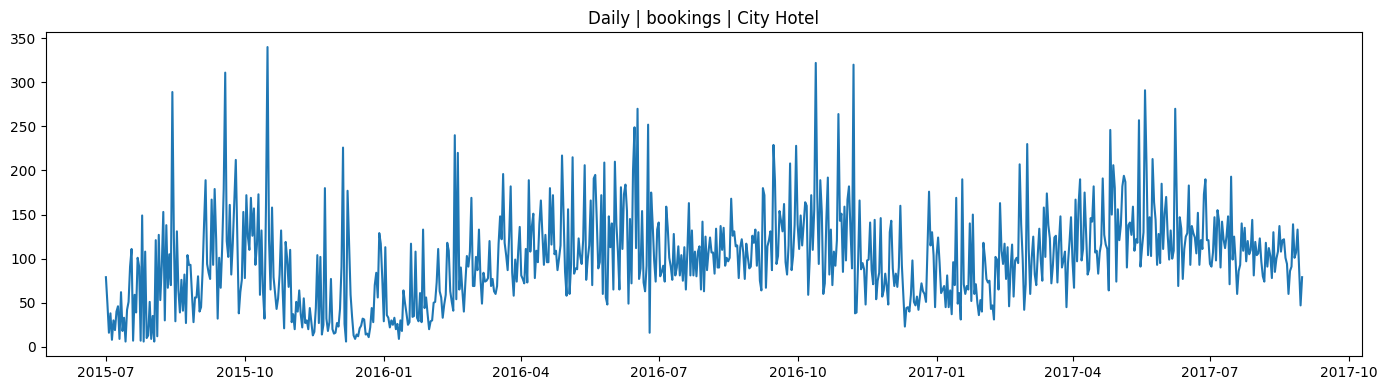

Saved: /kaggle/working/eda_daily_bookings_City_Hotel.png


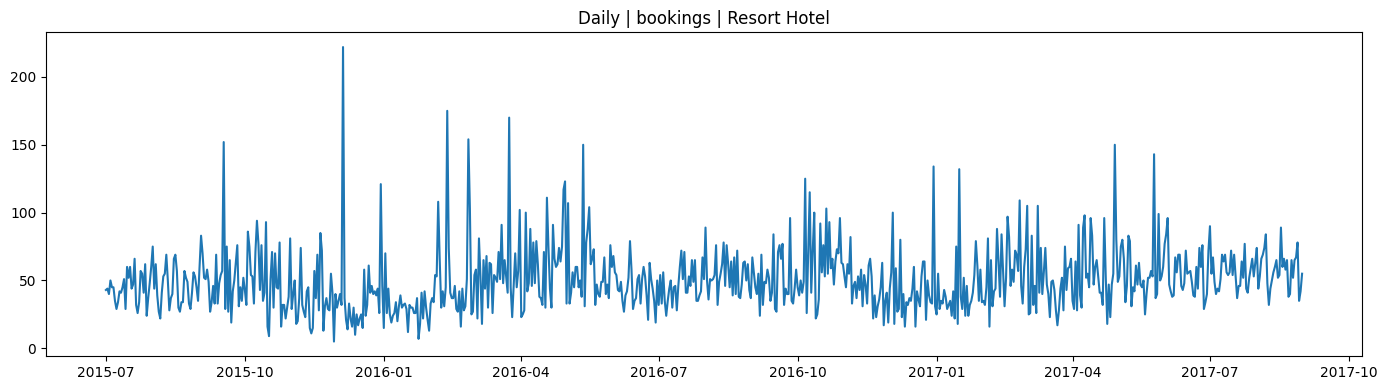

Saved: /kaggle/working/eda_daily_bookings_Resort_Hotel.png


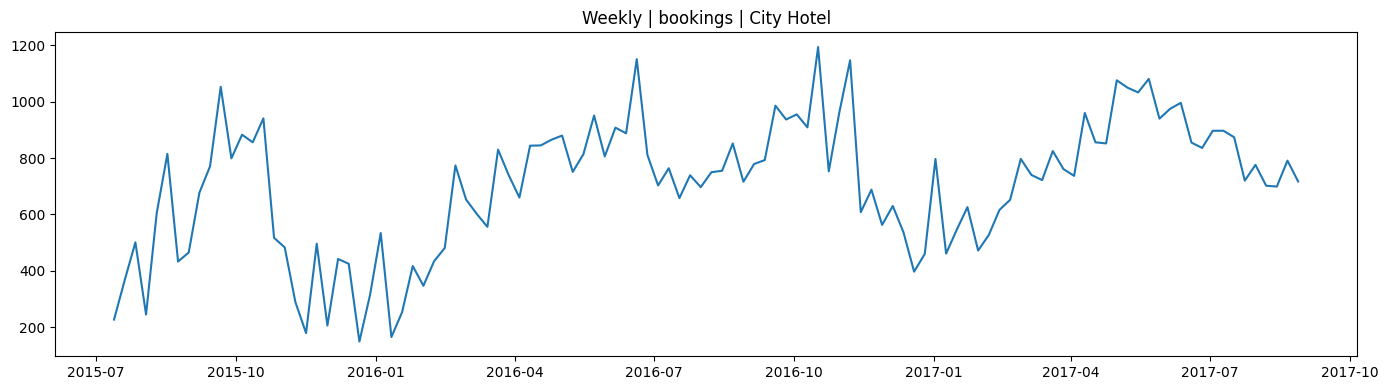

Saved: /kaggle/working/eda_weekly_bookings_City_Hotel.png


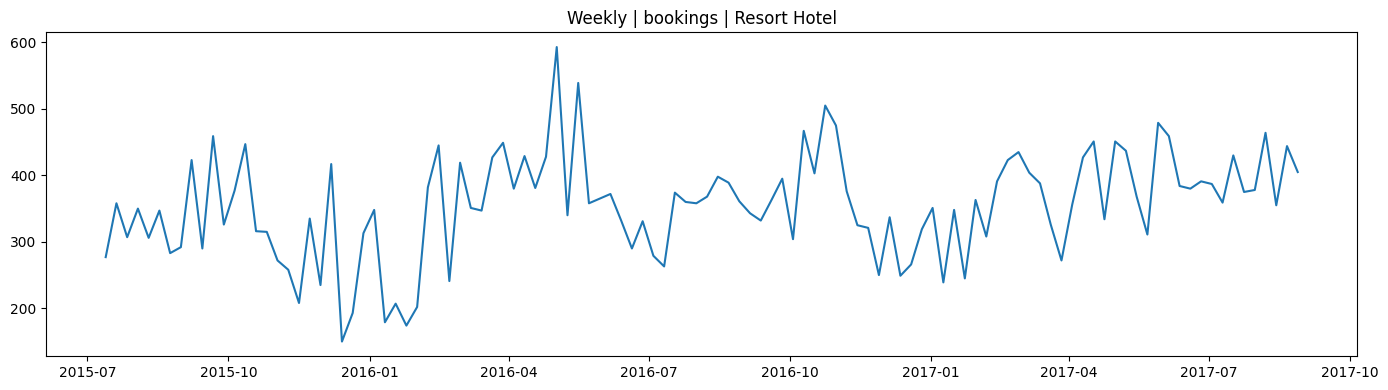

Saved: /kaggle/working/eda_weekly_bookings_Resort_Hotel.png


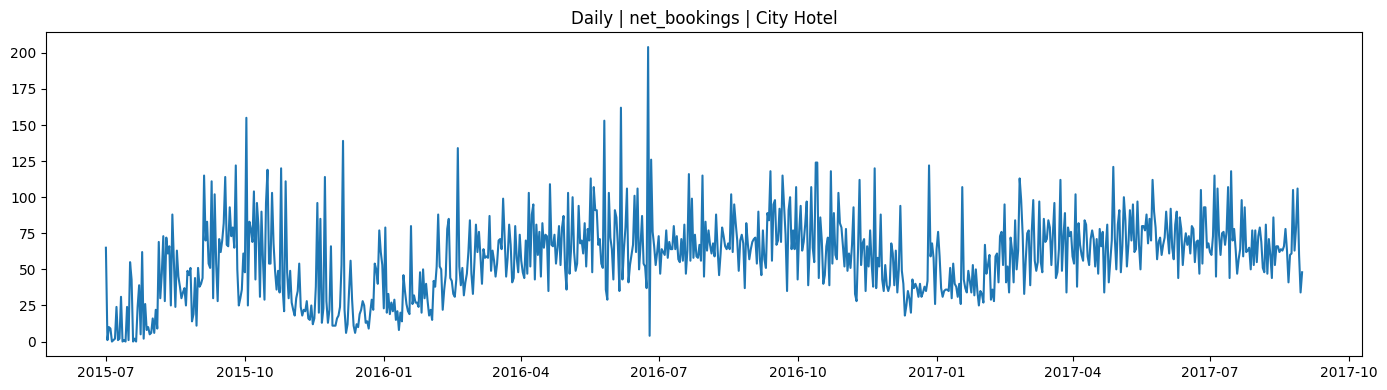

Saved: /kaggle/working/eda_daily_net_bookings_City_Hotel.png


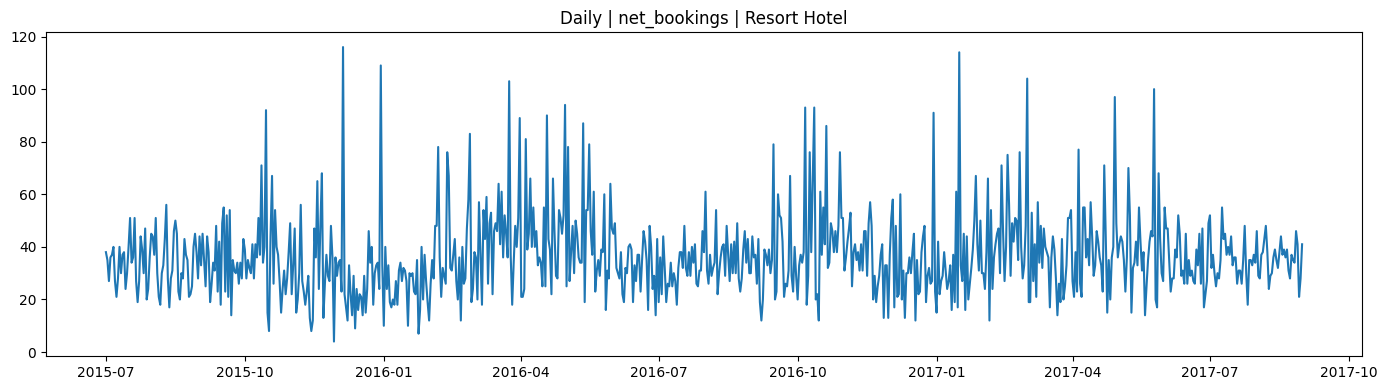

Saved: /kaggle/working/eda_daily_net_bookings_Resort_Hotel.png


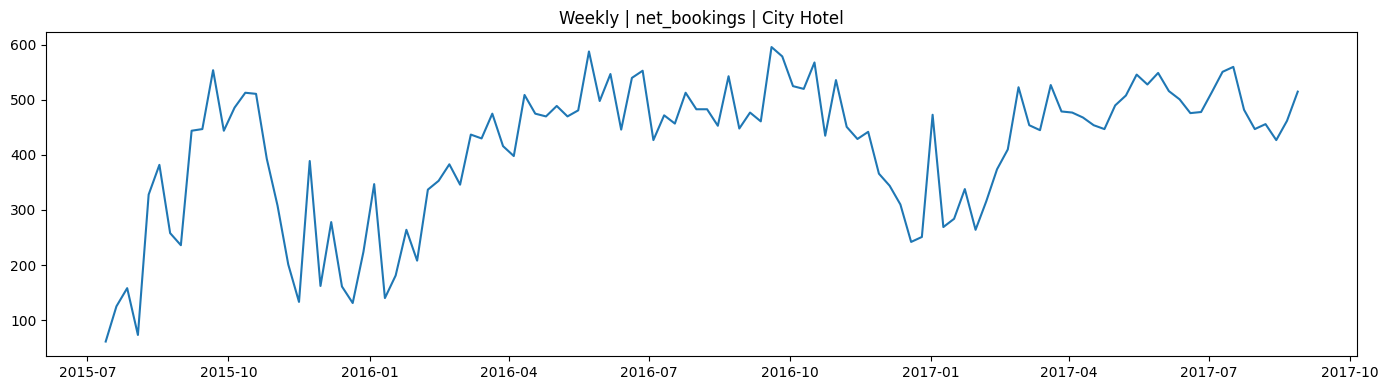

Saved: /kaggle/working/eda_weekly_net_bookings_City_Hotel.png


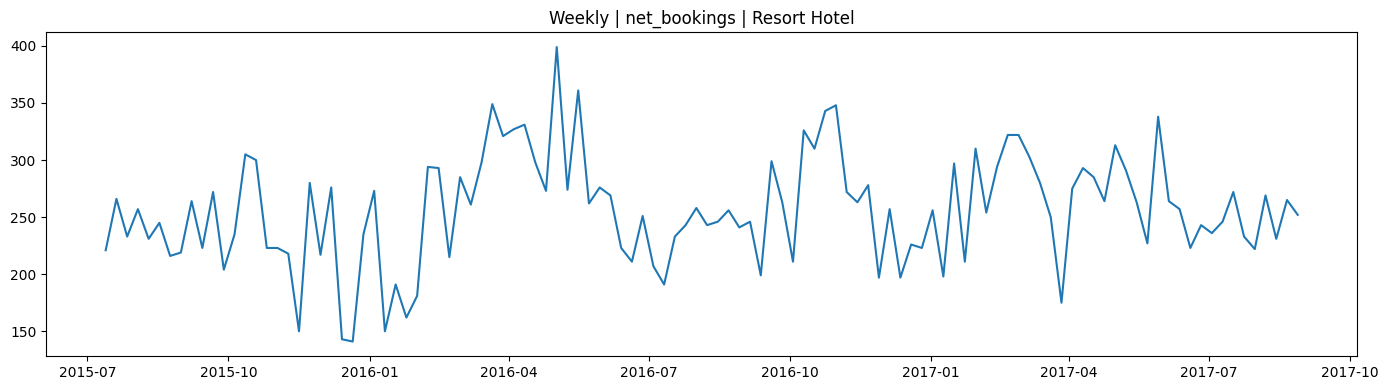

Saved: /kaggle/working/eda_weekly_net_bookings_Resort_Hotel.png


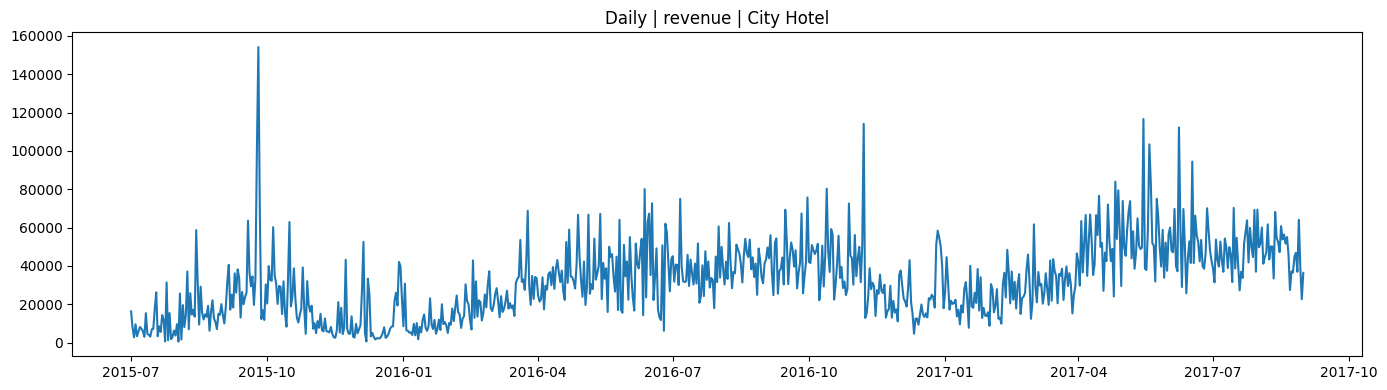

Saved: /kaggle/working/eda_daily_revenue_City_Hotel.png


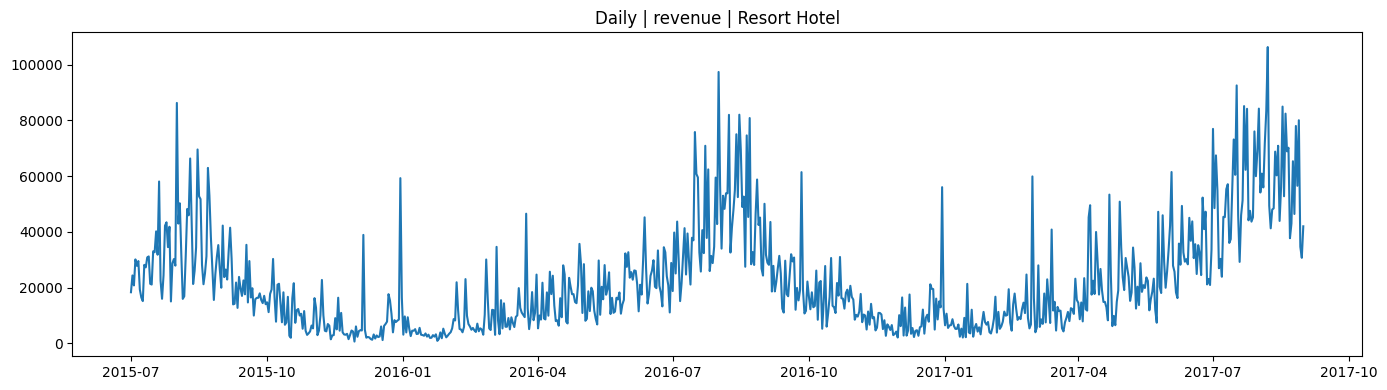

Saved: /kaggle/working/eda_daily_revenue_Resort_Hotel.png


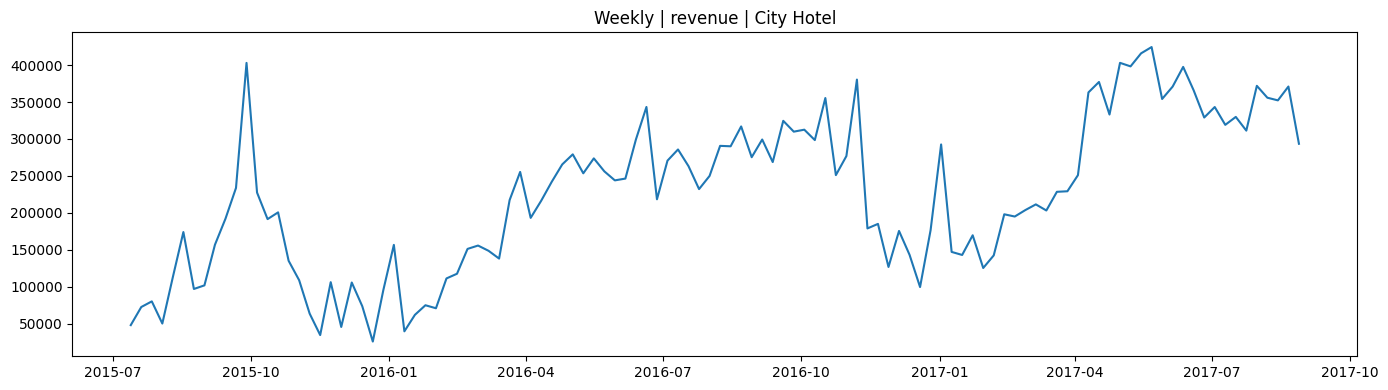

Saved: /kaggle/working/eda_weekly_revenue_City_Hotel.png


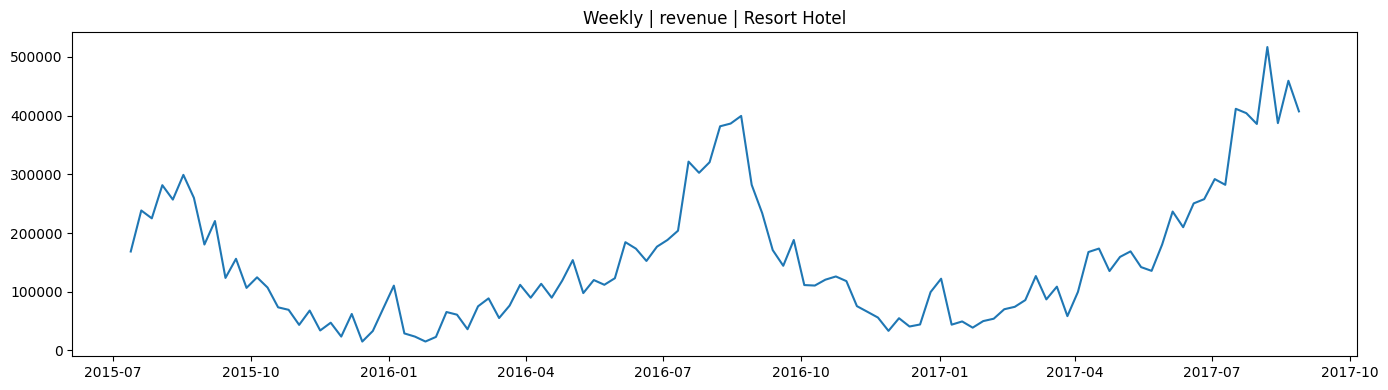

Saved: /kaggle/working/eda_weekly_revenue_Resort_Hotel.png


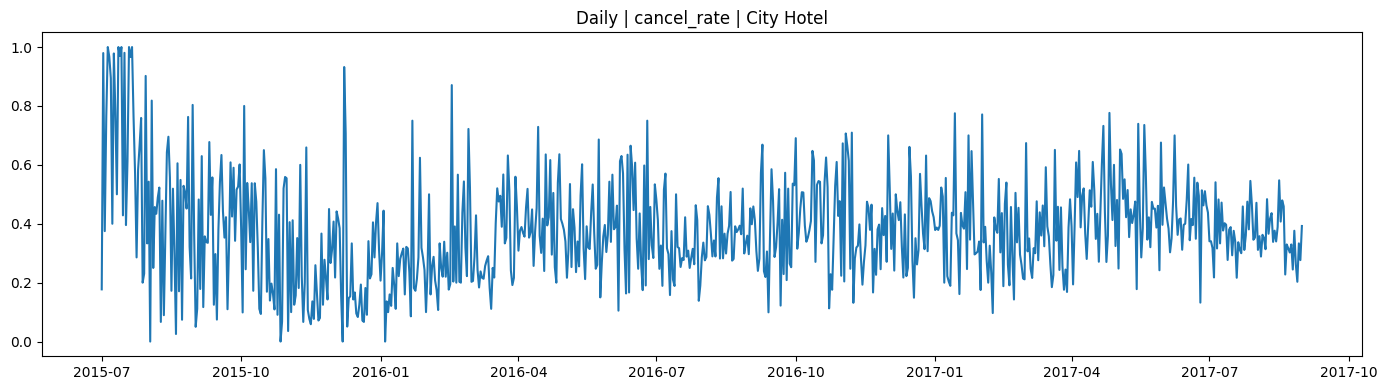

Saved: /kaggle/working/eda_daily_cancel_rate_City_Hotel.png


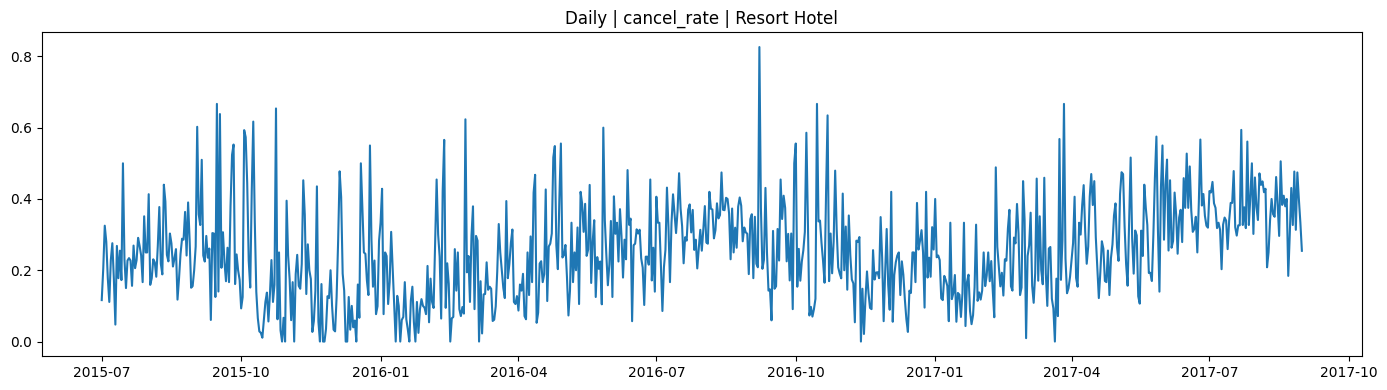

Saved: /kaggle/working/eda_daily_cancel_rate_Resort_Hotel.png


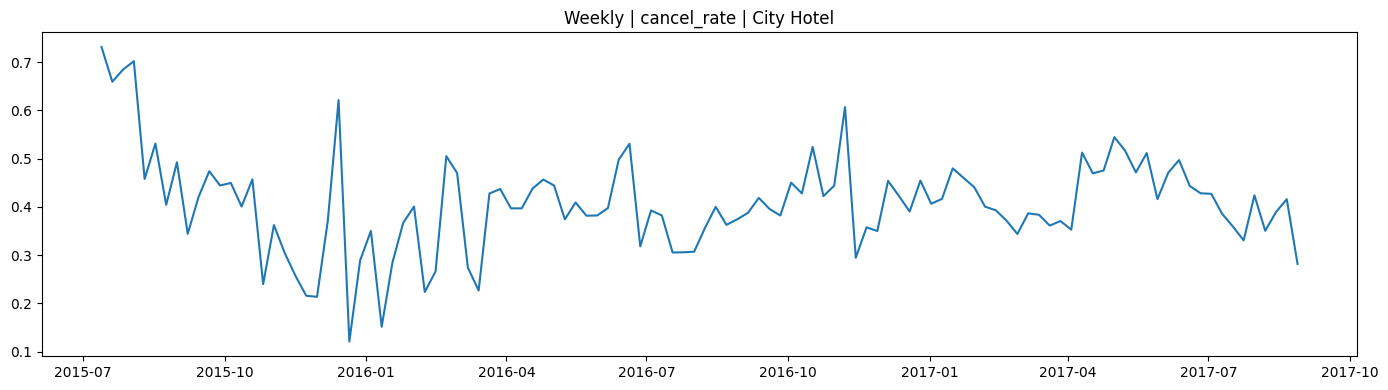

Saved: /kaggle/working/eda_weekly_cancel_rate_City_Hotel.png


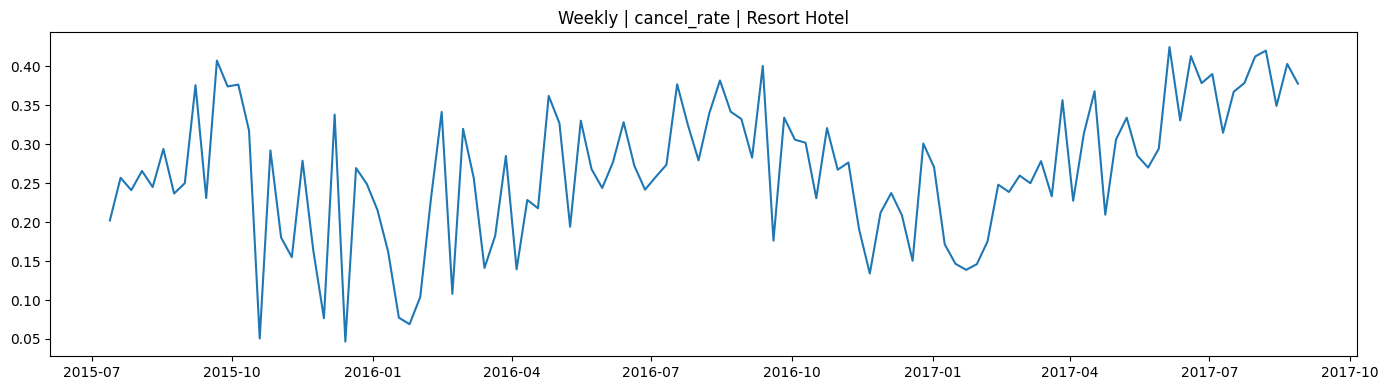

Saved: /kaggle/working/eda_weekly_cancel_rate_Resort_Hotel.png


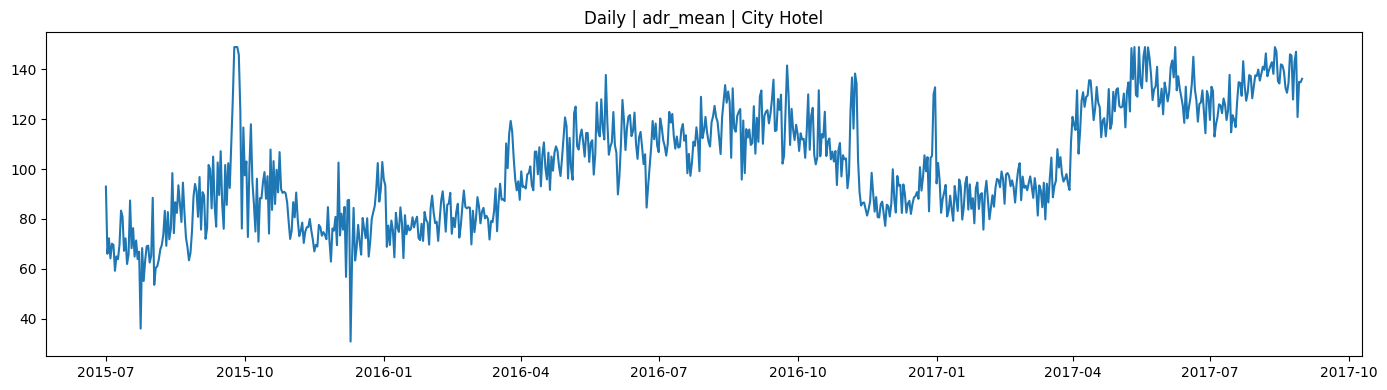

Saved: /kaggle/working/eda_daily_adr_mean_City_Hotel.png


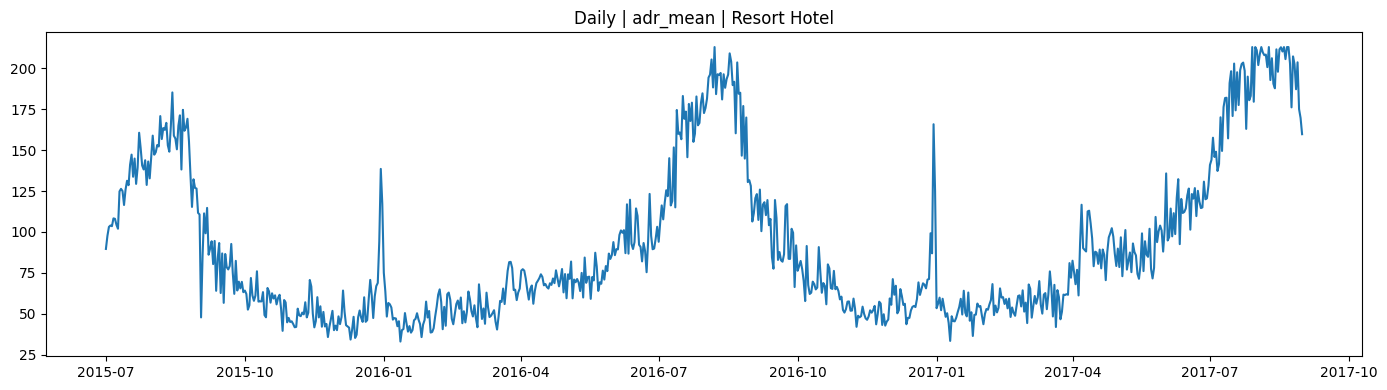

Saved: /kaggle/working/eda_daily_adr_mean_Resort_Hotel.png


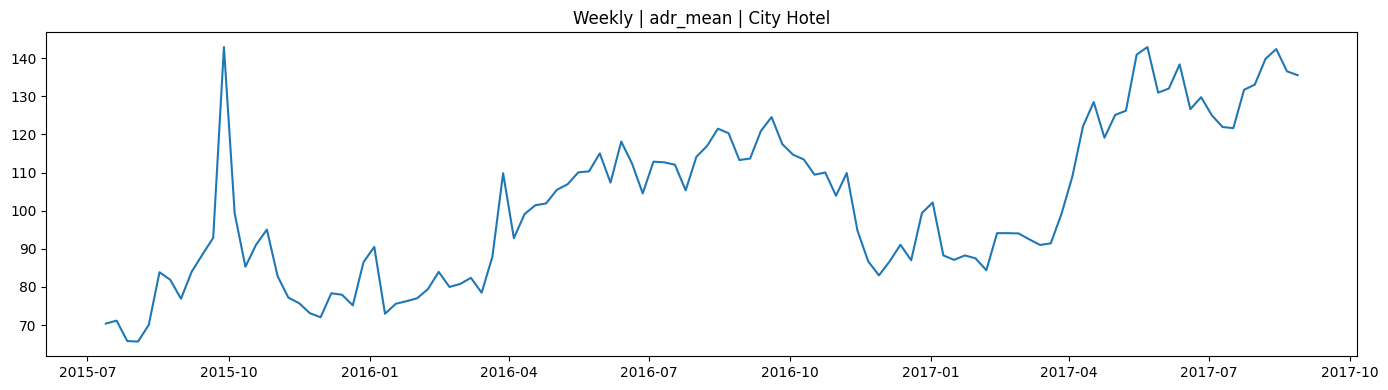

Saved: /kaggle/working/eda_weekly_adr_mean_City_Hotel.png


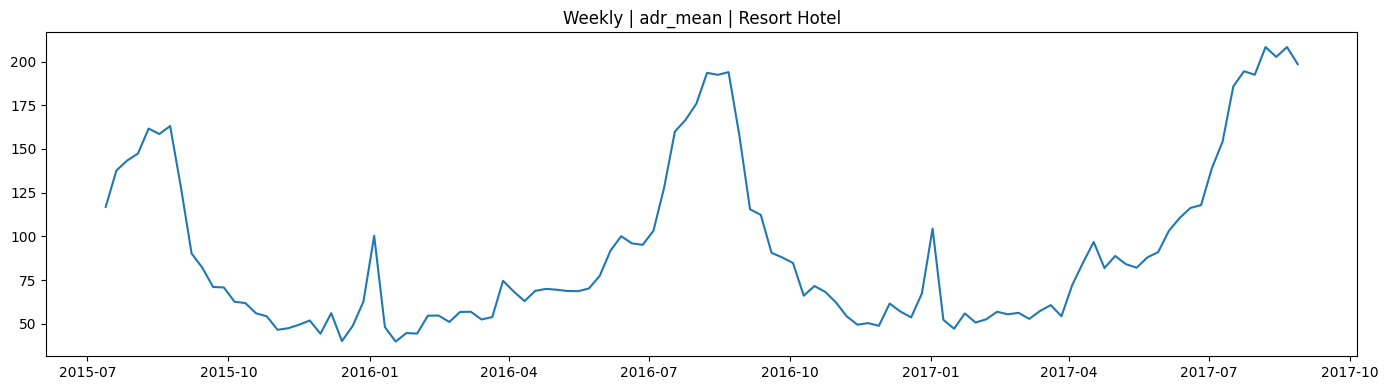

Saved: /kaggle/working/eda_weekly_adr_mean_Resort_Hotel.png


In [5]:
def plot_series(panel, col, title_prefix, fname_prefix):
    for uid in panel["unique_id"].unique():
        s = panel[panel["unique_id"]==uid].sort_values("ds")
        plt.figure(figsize=(14,4))
        plt.plot(s["ds"], s[col])
        plt.title(f"{title_prefix} | {col} | {uid}")
        plt.tight_layout()
        p = f"{OUTDIR}/{fname_prefix}_{col}_{uid.replace(' ','_')}.png"
        plt.savefig(p, dpi=150)
        plt.show()
        print("Saved:", p)

for c in ["bookings","net_bookings","revenue","cancel_rate","adr_mean"]:
    plot_series(daily, c, "Daily", "eda_daily")
    plot_series(weekly, c, "Weekly", "eda_weekly")


## Metrics, transforms, utilities

In [9]:
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def wape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.sum(np.abs(y_true))
    return np.sum(np.abs(y_true - y_pred)) / denom if denom != 0 else np.nan

def mape_safe(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])))

def smape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    mask = denom != 0
    return float(np.mean(2 * np.abs(y_pred[mask] - y_true[mask]) / denom[mask])) if mask.sum() else np.nan

def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    err = y_pred - y_true
    return {
        "MAE": float(np.mean(np.abs(err))),
        "RMSE": rmse(y_true, y_pred),
        "MAPE": float(mape_safe(y_true, y_pred)),
        "sMAPE": float(smape(y_true, y_pred)),
        "WAPE": float(wape(y_true, y_pred)),
        "Bias": float(np.sum(err)),
        "Mean_Forecast_Error": float(np.mean(err)),
        "Accuracy_1-WAPE": float(1 - wape(y_true, y_pred)) if not np.isnan(wape(y_true, y_pred)) else np.nan,
    }

def log1p_clip(y):
    y = np.asarray(y)
    return np.log1p(np.clip(y, 0, None))

def inv_log1p(yhat):
    return np.clip(np.expm1(yhat), 0, None)

def logit(p, eps=1e-6):
    p = np.asarray(p)
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def inv_logit(z):
    z = np.asarray(z)
    p = 1 / (1 + np.exp(-z))
    return np.clip(p, 0, 1)

def standardize_sf_cols(df_):
    df_ = df_.copy()
    ets_like = [c for c in df_.columns if c.lower() in ["ets", "autoets", "etsmodel"]]
    if "ETS" not in df_.columns and ets_like:
        df_ = df_.rename(columns={ets_like[0]:"ETS"})
    arima_like = [c for c in df_.columns if c.lower() in ["autoarima", "arima"]]
    if "AutoARIMA" not in df_.columns and arima_like:
        df_ = df_.rename(columns={arima_like[0]:"AutoARIMA"})
    return df_

def optimize_alpha(y_true, p_base, p_ml, grid=np.linspace(0, 1, 51)):
    best_a, best_w = 0.5, np.inf
    for a in grid:
        p = a * p_base + (1 - a) * p_ml
        w = wape(y_true, p)
        if w < best_w:
            best_w = w
            best_a = a
    return float(best_a), float(best_w)


## Backtest engine (hybrid per target type)

In [10]:
def build_models(season_length):
    models = []
    if ETSModel is not None:
        models.append(ETSModel(season_length=season_length))
    models += [AutoARIMA(season_length=season_length), SeasonalNaive(season_length=season_length)]
    return models

def lgbm_for_target(kind):
    if kind == "count":
        return lgb.LGBMRegressor(
            objective="poisson",
            n_estimators=3500,
            learning_rate=0.03,
            num_leaves=31,
            min_child_samples=10,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_alpha=0.2,
            reg_lambda=0.2,
            random_state=SEED,
            verbosity=-1
        )
    if kind == "rate":
        return lgb.LGBMRegressor(
            objective="regression",
            n_estimators=3000,
            learning_rate=0.03,
            num_leaves=31,
            min_child_samples=10,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_alpha=0.2,
            reg_lambda=0.2,
            random_state=SEED,
            verbosity=-1
        )
    return lgb.LGBMRegressor(
        objective="regression",
        n_estimators=3500,
        learning_rate=0.03,
        num_leaves=63,
        min_child_samples=10,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.2,
        reg_lambda=0.2,
        random_state=SEED,
        verbosity=-1
    )

def backtest_one(panel, target, kind, freq, h, step, n_windows, season_length, lags, date_features, cap_map=None):
    ydf = panel[["unique_id","ds",target]].rename(columns={target:"y"}).copy()
    ydf["ds"] = pd.to_datetime(ydf["ds"])
    ydf = ydf.sort_values(["unique_id","ds"]).reset_index(drop=True)

    y_sf = ydf.copy()
    y_ml = ydf.copy()

    inv_fn = None

    if kind == "rate":
        y_sf["y"] = logit(y_sf["y"])
        y_ml["y"] = logit(y_ml["y"])
        inv_fn = inv_logit

    if kind == "value":
        y_sf["y"] = log1p_clip(y_sf["y"])
        y_ml["y"] = log1p_clip(y_ml["y"])
        inv_fn = inv_log1p

    sf = StatsForecast(models=build_models(season_length), freq=freq, n_jobs=-1)
    cv_sf = sf.cross_validation(df=y_sf, h=h, step_size=step, n_windows=n_windows)
    cv_sf = standardize_sf_cols(cv_sf)

    fcst = MLForecast(
        models=[lgbm_for_target(kind)],
        freq=freq,
        lags=lags,
        date_features=date_features
    )

    cv_ml = fcst.cross_validation(
        df=y_ml,
        h=h,
        step_size=step,
        n_windows=n_windows,
        dropna=False
    ).rename(columns={"LGBMRegressor":"LGBM_t"})

    if kind in ["rate","value"]:
        cv_ml["LGBM"] = inv_fn(cv_ml["LGBM_t"].values)
        cv_ml = cv_ml.drop(columns=["LGBM_t"])
        cv_sf = cv_sf.copy()
        for c in ["ETS","AutoARIMA","SeasonalNaive"]:
            if c in cv_sf.columns:
                cv_sf[c] = inv_fn(cv_sf[c].values)
    else:
        cv_ml = cv_ml.rename(columns={"LGBM_t":"LGBM"})

    cv = cv_sf.merge(
        cv_ml[["unique_id","ds","cutoff","LGBM"]],
        on=["unique_id","ds","cutoff"],
        how="inner"
    )

    cv = cv.merge(ydf.rename(columns={"y":"y_orig"}), on=["unique_id","ds"], how="left")
    cv["y"] = cv["y_orig"]
    cv = cv.drop(columns=["y_orig"])

    if kind == "count":
        for c in ["ETS","AutoARIMA","SeasonalNaive","LGBM"]:
            if c in cv.columns:
                cv[c] = cv[c].clip(lower=0)

    if kind == "rate":
        for c in ["ETS","AutoARIMA","SeasonalNaive","LGBM"]:
            if c in cv.columns:
                cv[c] = np.clip(cv[c], 0, 1)

    if kind == "value":
        if cap_map is not None:
            for c in ["ETS","AutoARIMA","SeasonalNaive","LGBM"]:
                if c in cv.columns:
                    cv[c] = cv.apply(lambda r: min(r[c], cap_map.get(r["unique_id"], r[c])), axis=1)
        for c in ["ETS","AutoARIMA","SeasonalNaive","LGBM"]:
            if c in cv.columns:
                cv[c] = cv[c].clip(lower=0)

    base_candidates = [c for c in ["ETS","AutoARIMA","SeasonalNaive"] if c in cv.columns]

    alpha_map = {}
    base_map = {}

    for uid, sub in cv.groupby("unique_id"):
        y_true = sub["y"].values
        p_ml = sub["LGBM"].values

        best_a, best_w, best_base = 0.5, np.inf, base_candidates[0]
        for b in base_candidates:
            a, w = optimize_alpha(y_true, sub[b].values, p_ml)
            if w < best_w:
                best_a, best_w, best_base = a, w, b

        alpha_map[uid] = best_a
        base_map[uid] = best_base

    cv["alpha"] = cv["unique_id"].map(alpha_map)
    cv["hybrid_base"] = cv["unique_id"].map(base_map)

    base_vals = np.zeros(len(cv))
    for b in base_candidates:
        base_vals = np.where(cv["hybrid_base"].eq(b), cv[b].values, base_vals)

    cv["Hybrid"] = cv["alpha"].values * base_vals + (1 - cv["alpha"].values) * cv["LGBM"].values

    cv["freq"] = freq
    cv["target"] = target

    metric_rows = []
    model_cols = base_candidates + ["LGBM","Hybrid"]

    for uid, sub in cv.groupby("unique_id"):
        y_true = sub["y"].values
        for mcol in model_cols:
            m = evaluate(y_true, sub[mcol].values)
            metric_rows.append({
                "freq": freq,
                "target": target,
                "unique_id": uid,
                "model": mcol,
                **m,
                "alpha": float(sub["alpha"].iloc[0]) if mcol=="Hybrid" else np.nan,
                "hybrid_base": str(sub["hybrid_base"].iloc[0]) if mcol=="Hybrid" else np.nan
            })

    metrics = pd.DataFrame(metric_rows)
    return metrics, cv


## Run backtests (base targets), pick best, derive stable targets, save

In [11]:
base_targets = {
    "bookings":      {"kind":"count"},
    "room_nights":   {"kind":"count"},
    "guests_total":  {"kind":"count"},
    "adults_total":  {"kind":"count"},
    "cancel_rate":   {"kind":"rate"},
    "adr_mean":      {"kind":"value"},
}

DAILY_CFG = dict(freq="D", h=30, step=30, n_windows=10, season_length=7, lags=[1,7,14,28,56], date_features=["dayofweek","month","week","dayofyear","year"])
WEEKLY_CFG = dict(freq="W-MON", h=13, step=13, n_windows=6, season_length=52, lags=[1,2,4,8,13,26,52], date_features=["month","week","year"])

all_metrics = []
daily_bt_all = []
weekly_bt_all = []

for t, meta in base_targets.items():
    m, bt = backtest_one(daily, t, meta["kind"], cap_map=adr_cap_daily if t=="adr_mean" else None, **DAILY_CFG)
    all_metrics.append(m)
    daily_bt_all.append(bt)
    gc.collect()

for t, meta in base_targets.items():
    m, bt = backtest_one(weekly, t, meta["kind"], cap_map=adr_cap_weekly if t=="adr_mean" else None, **WEEKLY_CFG)
    all_metrics.append(m)
    weekly_bt_all.append(bt)
    gc.collect()

metrics_df = pd.concat(all_metrics, ignore_index=True)
daily_bt = pd.concat(daily_bt_all, ignore_index=True)
weekly_bt = pd.concat(weekly_bt_all, ignore_index=True)

metrics_df.to_csv(f"{OUTDIR}/metrics_all_models_base_targets.csv", index=False)
daily_bt.to_csv(f"{OUTDIR}/daily_backtest_all_models_base_targets.csv", index=False)
weekly_bt.to_csv(f"{OUTDIR}/weekly_backtest_all_models_base_targets.csv", index=False)

best_models = (
    metrics_df.sort_values(["freq","target","unique_id","WAPE","RMSE","MAE"])
              .groupby(["freq","target","unique_id"], as_index=False)
              .first()
)
best_models.to_csv(f"{OUTDIR}/best_models_base_targets.csv", index=False)

display(best_models.head(20))
print("Saved base backtests + best models.")


freq        target     unique_id      model         MAE        RMSE      MAPE     sMAPE      WAPE          Bias  Mean_Forecast_Error  Accuracy_1-WAPE  alpha    hybrid_base
0       D      adr_mean    City Hotel     Hybrid    9.420758   12.143352  0.084312  0.086627  0.083903  -1168.298086            -3.894327         0.916097   0.68            ETS
1       D      adr_mean  Resort Hotel     Hybrid   12.975363   18.892936  0.137494  0.141618  0.134745  -1737.001872            -5.790006         0.865255   0.48      AutoARIMA
2       D  adults_total    City Hotel     Hybrid   55.517397   74.864409  0.315067  0.282913  0.273319   -303.590304            -1.011968         0.726681   0.40            ETS
3       D  adults_total  Resort Hotel     Hybrid   28.116974   38.824221  0.358060  0.296339  0.291257    472.354948             1.574516         0.708743   0.64            ETS
4       D      bookings    City Hotel     Hybrid   30.514130   41.997864  0.321212  0.287740  0.281652   -105.644653            -0.352149         0.718348   0.46            ETS
5       D      bookings  Resort Hotel     Hybrid   14.957710   20.342085  0.339077  0.286741  0.286217    215.352541             0.717842         0.713783   0.58            ETS
6       D   cancel_rate    City Hotel     Hybrid    0.105335    0.135925  0.319392  0.274570  0.268557      0.372419             0.001241         0.731443   0.76      AutoARIMA
7       D   cancel_rate  Resort Hotel     Hybrid    0.091181    0.119213  0.470892  0.389298  0.332163    -12.121136            -0.040404         0.667837   0.74      AutoARIMA
8       D  guests_total    City Hotel     Hybrid   61.221644   79.942051  0.346578  0.297826  0.284743   1048.732600             3.495775         0.715257   0.48            ETS
9       D  guests_total  Resort Hotel     Hybrid   32.624296   44.602450  0.383077  0.318107  0.310255    -11.484569            -0.038282         0.689745   0.68      AutoARIMA
10      D   room_nights    City Hotel     Hybrid   89.879023  123.502564  0.300497  0.275980  0.265469  -4785.514708           -15.951716         0.734531   0.56            ETS
11      D   room_nights  Resort Hotel     Hybrid   76.733940  115.576969  0.441354  0.351608  0.337124   -264.529492            -0.881765         0.662876   0.66            ETS
12  W-MON      adr_mean    City Hotel     Hybrid    9.023566   12.640816  0.083447  0.090420  0.081916   -500.449987            -6.416025         0.918084   0.36      AutoARIMA
13  W-MON      adr_mean  Resort Hotel     Hybrid   16.222122   26.133667  0.143146  0.154621  0.167072   -737.815122            -9.459168         0.832928   0.26  SeasonalNaive
14  W-MON  adults_total    City Hotel     Hybrid  252.052280  323.464019  0.163467  0.179308  0.169896 -11094.904485          -142.242365         0.830104   0.64            ETS
15  W-MON  adults_total  Resort Hotel     Hybrid  103.649302  136.016838  0.156159  0.150978  0.148563   -361.815360            -4.638658         0.851437   0.80            ETS
16  W-MON      bookings    City Hotel     Hybrid  128.912866  167.652074  0.157235  0.165581  0.162977  -3825.369711           -49.043201         0.837023   0.50            ETS
17  W-MON      bookings  Resort Hotel     Hybrid   47.783549   63.209077  0.124889  0.128189  0.127597  -1320.470682           -16.929111         0.872403   0.52            ETS
18  W-MON   cancel_rate    City Hotel  AutoARIMA    0.056212    0.074321  0.144577  0.137890  0.137681      0.139543             0.001789         0.862319   1.00      AutoARIMA
19  W-MON   cancel_rate  Resort Hotel     Hybrid    0.064138    0.077462  0.242275  0.249461  0.227186     -2.165579            -0.027764         0.772814   0.62  SeasonalNaive

Saved base backtests + best models.


## Best historical forecasts (backtest) + Derived coherent targets + Detailed stats

In [12]:
def apply_best(pred_df, best_df):
    f = pred_df.copy()

    for c in ["freq","target","unique_id"]:
        f[c] = f[c].astype(str).str.strip()
    bm = best_df.copy()
    for c in ["freq","target","unique_id"]:
        bm[c] = bm[c].astype(str).str.strip()

    f = f.merge(bm[["freq","target","unique_id","model","alpha","hybrid_base"]], on=["freq","target","unique_id"], how="left", suffixes=("", "_bm"))

    f["alpha"] = f["alpha"].fillna(0.5)
    f["hybrid_base"] = f["hybrid_base"].fillna("ETS")

    def pick(row):
        m = row["model"]
        if m in ["ETS","AutoARIMA","SeasonalNaive","LGBM","Hybrid"]:
            return row.get(m, np.nan)
        return np.nan

    f["yhat_best"] = f.apply(pick, axis=1)
    return f

daily_best_base = apply_best(daily_bt, best_models[best_models["freq"]=="D"])
weekly_best_base = apply_best(weekly_bt, best_models[best_models["freq"]=="W-MON"])

daily_best_base.to_csv(f"{OUTDIR}/daily_backtest_best_base_targets.csv", index=False)
weekly_best_base.to_csv(f"{OUTDIR}/weekly_backtest_best_base_targets.csv", index=False)

def wide_best(df_best):
    return df_best.pivot_table(
        index=["freq","unique_id","cutoff","ds"],
        columns="target",
        values=["y","yhat_best"],
        aggfunc="first"
    )

daily_w = wide_best(daily_best_base)
weekly_w = wide_best(weekly_best_base)

def derive_from_components(w):
    out = w.copy()
    out[("yhat_best","canceled_bookings")] = out[("yhat_best","bookings")] * out[("yhat_best","cancel_rate")]
    out[("yhat_best","net_bookings")] = out[("yhat_best","bookings")] * (1 - out[("yhat_best","cancel_rate")])
    out[("yhat_best","revenue")] = out[("yhat_best","room_nights")] * out[("yhat_best","adr_mean")]

    out[("y","canceled_bookings")] = out[("y","bookings")] * out[("y","cancel_rate")]
    out[("y","net_bookings")] = out[("y","bookings")] * (1 - out[("y","cancel_rate")])
    out[("y","revenue")] = out[("y","room_nights")] * out[("y","adr_mean")]
    return out

daily_w = derive_from_components(daily_w)
weekly_w = derive_from_components(weekly_w)

def long_from_wide(w, freq_label):
    y = w["y"].stack().rename("y").reset_index()
    yhat = w["yhat_best"].stack().rename("yhat_best").reset_index()
    out = y.merge(yhat, on=["freq","unique_id","cutoff","ds","target"], how="inner")
    out["freq"] = freq_label
    return out

daily_best_hist = long_from_wide(daily_w, "D")
weekly_best_hist = long_from_wide(weekly_w, "W-MON")

daily_best_hist.to_csv(f"{OUTDIR}/daily_backtest_best_all_targets.csv", index=False)
weekly_best_hist.to_csv(f"{OUTDIR}/weekly_backtest_best_all_targets.csv", index=False)

def summarize(bt):
    bt = bt.dropna(subset=["yhat_best"]).copy()
    bt["error"] = bt["yhat_best"] - bt["y"]
    bt["abs_error"] = bt["error"].abs()
    bt["sq_error"] = bt["error"] ** 2
    bt["ape"] = np.where(bt["y"] != 0, bt["abs_error"] / np.abs(bt["y"]), np.nan)
    denom = (np.abs(bt["y"]) + np.abs(bt["yhat_best"]))
    bt["sape"] = np.where(denom != 0, 2 * bt["abs_error"] / denom, np.nan)

    g = bt.groupby(["freq","target","unique_id"], as_index=False).agg(
        n=("y","count"),
        actual_sum=("y","sum"),
        forecast_sum=("yhat_best","sum"),
        MAE=("abs_error","mean"),
        RMSE=("sq_error", lambda x: float(np.sqrt(np.mean(x)))),
        WAPE=("abs_error", lambda x: float(x.sum() / bt.loc[x.index, "y"].abs().sum()) if bt.loc[x.index, "y"].abs().sum() != 0 else np.nan),
        MAPE=("ape","mean"),
        sMAPE=("sape","mean"),
        Bias=("error","sum"),
        Bias_pct=("error", lambda x: float(x.sum() / bt.loc[x.index, "y"].abs().sum()) if bt.loc[x.index, "y"].abs().sum() != 0 else np.nan),
    )
    return g

detailed_stats = pd.concat([summarize(daily_best_hist), summarize(weekly_best_hist)], ignore_index=True)
detailed_stats.to_csv(f"{OUTDIR}/detailed_forecast_stats_best_model.csv", index=False)

display(detailed_stats.sort_values(["freq","target","unique_id"]).head(40))
print("Saved:", f"{OUTDIR}/detailed_forecast_stats_best_model.csv")


freq             target     unique_id    n    actual_sum  forecast_sum           MAE          RMSE      WAPE      MAPE     sMAPE          Bias  Bias_pct
0       D           adr_mean    City Hotel  300  3.368455e+04  3.251625e+04      9.420758     12.143352  0.083903  0.084312  0.086627 -1.168298e+03 -0.034684
1       D           adr_mean  Resort Hotel  300  2.888875e+04  2.715175e+04     12.975363     18.892936  0.134745  0.137494  0.141618 -1.737002e+03 -0.060127
2       D       adults_total    City Hotel  300  6.093700e+04  6.063341e+04     55.517397     74.864409  0.273319  0.315067  0.282913 -3.035903e+02 -0.004982
3       D       adults_total  Resort Hotel  300  2.896100e+04  2.943335e+04     28.116974     38.824221  0.291257  0.358060  0.296339  4.723549e+02  0.016310
4       D           bookings    City Hotel  300  3.250200e+04  3.239636e+04     30.514130     41.997864  0.281652  0.321212  0.287740 -1.056447e+02 -0.003250
5       D           bookings  Resort Hotel  300  1.567800e+04  1.589335e+04     14.957710     20.342085  0.286217  0.339077  0.286741  2.153525e+02  0.013736
6       D        cancel_rate    City Hotel  300  1.176678e+02  1.180402e+02      0.105335      0.135925  0.268557  0.319392  0.274570  3.724193e-01  0.003165
7       D        cancel_rate  Resort Hotel  300  8.235221e+01  7.023108e+01      0.091181      0.119213  0.332163  0.470892  0.389298 -1.212114e+01 -0.147187
8       D  canceled_bookings    City Hotel  300  1.375700e+04  1.306331e+04     21.334399     32.227727  0.465241  0.640120  0.465982 -6.936929e+02 -0.050425
9       D  canceled_bookings  Resort Hotel  300  4.597000e+03  3.808296e+03      6.876348      9.944988  0.448750  0.655485  0.496115 -7.887037e+02 -0.171569
10      D       guests_total    City Hotel  300  6.450200e+04  6.555073e+04     61.221644     79.942051  0.284743  0.346578  0.297826  1.048733e+03  0.016259
11      D       guests_total  Resort Hotel  300  3.154600e+04  3.153452e+04     32.624296     44.602450  0.310255  0.383077  0.318107 -1.148457e+01 -0.000364
12      D       net_bookings    City Hotel  300  1.874500e+04  1.933305e+04     16.131909     20.589941  0.258179  0.297197  0.262260  5.880482e+02  0.031371
13      D       net_bookings  Resort Hotel  300  1.108100e+04  1.208506e+04     11.366905     15.242150  0.307740  0.381572  0.300733  1.004056e+03  0.090611
14      D            revenue    City Hotel  300  1.169244e+07  1.077801e+07  10550.054092  15100.700482  0.270689  0.308401  0.290757 -9.144351e+05 -0.078207
15      D            revenue  Resort Hotel  300  7.358079e+06  6.847410e+06   7689.825247  11535.406405  0.313526  0.460217  0.380690 -5.106689e+05 -0.069402
16      D        room_nights    City Hotel  300  1.015700e+05  9.678449e+04     89.879023    123.502564  0.265469  0.300497  0.275980 -4.785515e+03 -0.047115
17      D        room_nights  Resort Hotel  300  6.828400e+04  6.801947e+04     76.733940    115.576969  0.337124  0.441354  0.351608 -2.645295e+02 -0.003874
18  W-MON           adr_mean    City Hotel   78  8.592221e+03  8.091771e+03      9.023566     12.640816  0.081916  0.083447  0.090420 -5.004500e+02 -0.058245
19  W-MON           adr_mean  Resort Hotel   78  7.573534e+03  6.835719e+03     16.222122     26.133667  0.167072  0.143146  0.154621 -7.378151e+02 -0.097420
20  W-MON       adults_total    City Hotel   78  1.157180e+05  1.046231e+05    252.052280    323.464019  0.169896  0.163467  0.179308 -1.109490e+04 -0.095879
21  W-MON       adults_total  Resort Hotel   78  5.441900e+04  5.405718e+04    103.649302    136.016838  0.148563  0.156159  0.150978 -3.618154e+02 -0.006649
22  W-MON           bookings    City Hotel   78  6.169700e+04  5.787163e+04    128.912866    167.652074  0.162977  0.157235  0.165581 -3.825370e+03 -0.062003
23  W-MON           bookings  Resort Hotel   78  2.921000e+04  2.788953e+04     47.783549     63.209077  0.127597  0.124889  0.128189 -1.320471e+03 -0.045206
24  W-MON        cancel_rate    City Hotel   78  3.1845

Saved: /kaggle/working/detailed_forecast_stats_best_model.csv


## Train full models on all history, forecast 2 years, apply best per base target, derive final + plots + save models

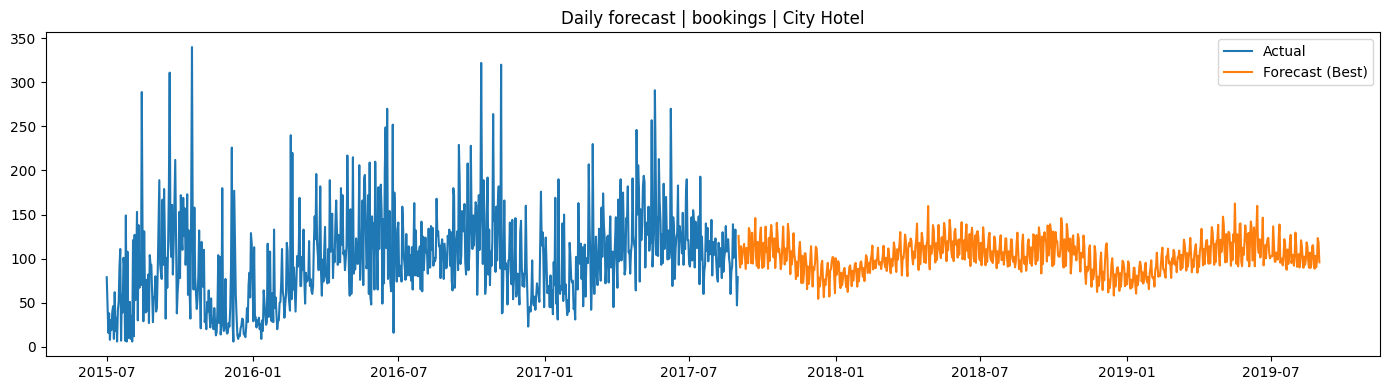

Saved: /kaggle/working/daily_forecast_bookings_City_Hotel.png


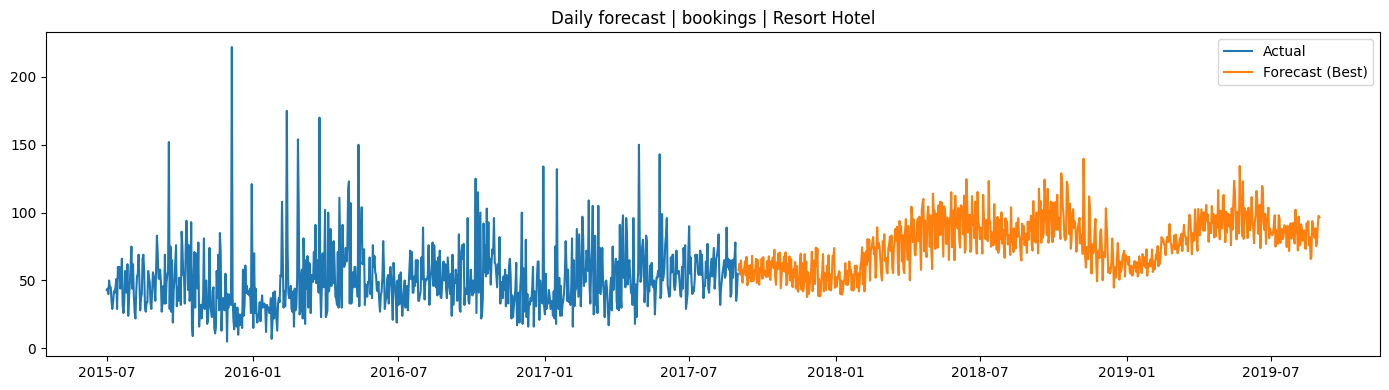

Saved: /kaggle/working/daily_forecast_bookings_Resort_Hotel.png


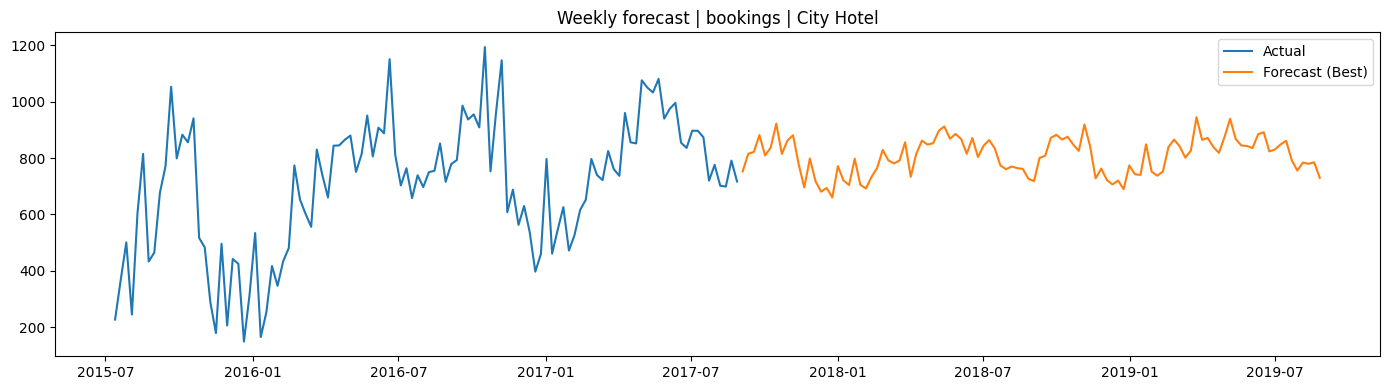

Saved: /kaggle/working/weekly_forecast_bookings_City_Hotel.png


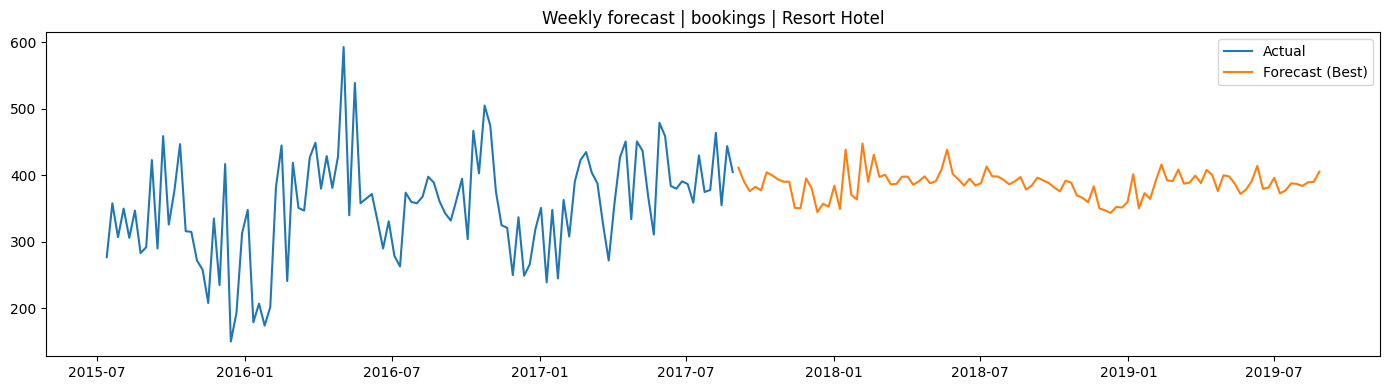

Saved: /kaggle/working/weekly_forecast_bookings_Resort_Hotel.png


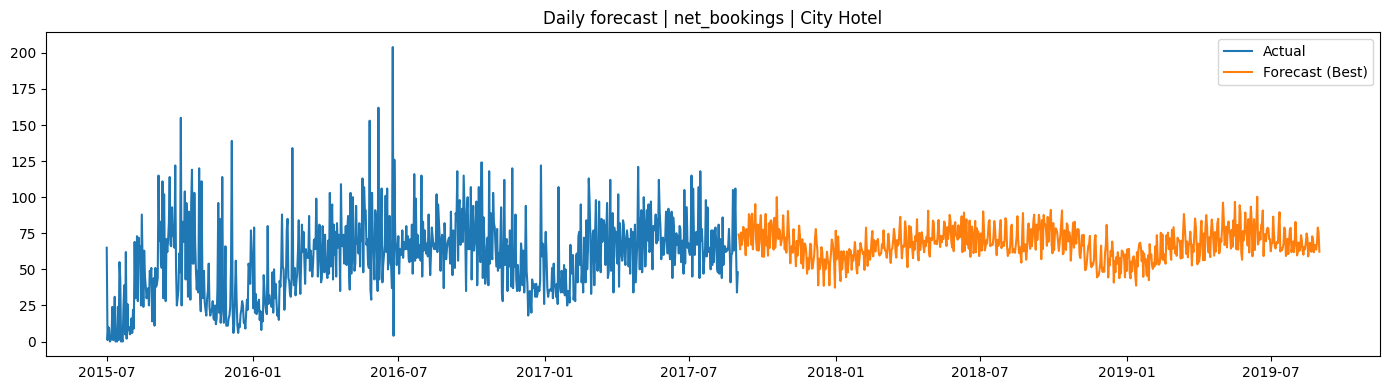

Saved: /kaggle/working/daily_forecast_net_bookings_City_Hotel.png


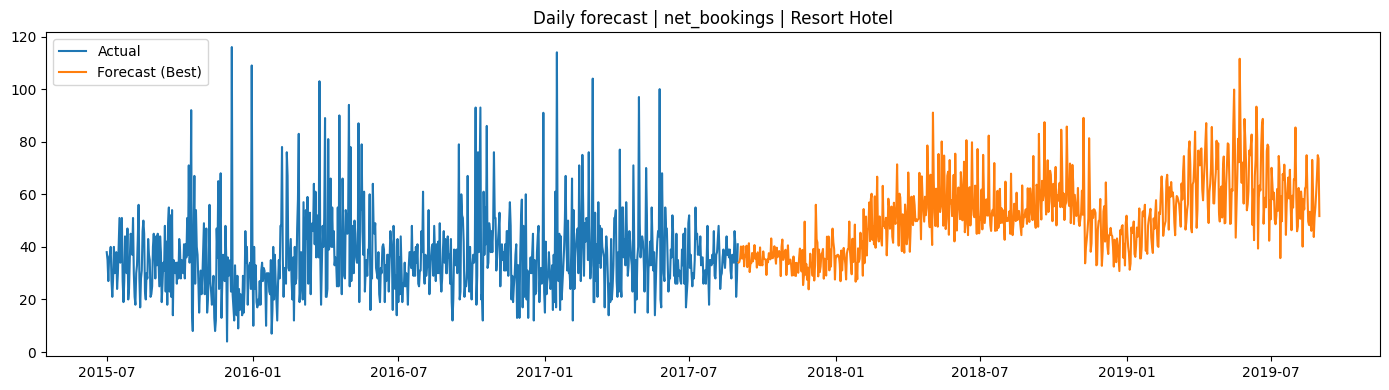

Saved: /kaggle/working/daily_forecast_net_bookings_Resort_Hotel.png


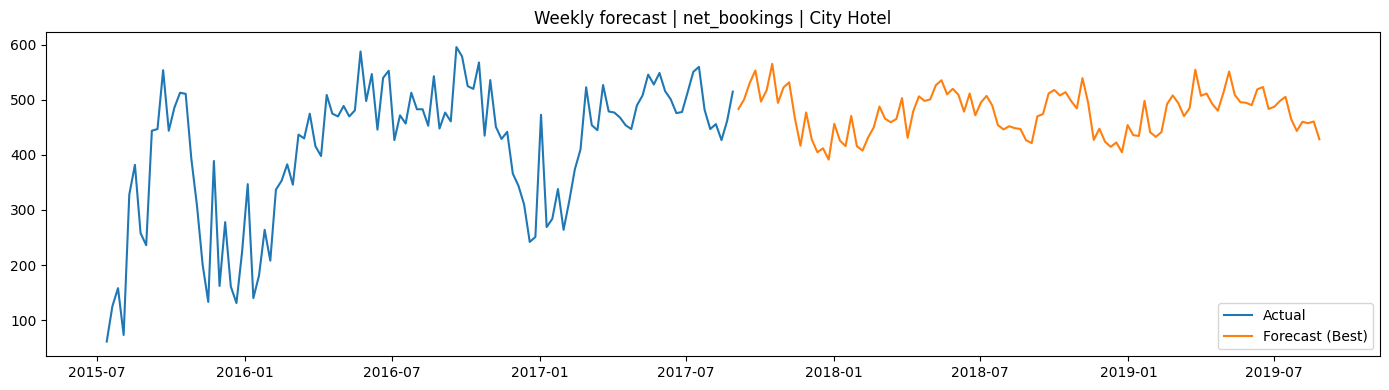

Saved: /kaggle/working/weekly_forecast_net_bookings_City_Hotel.png


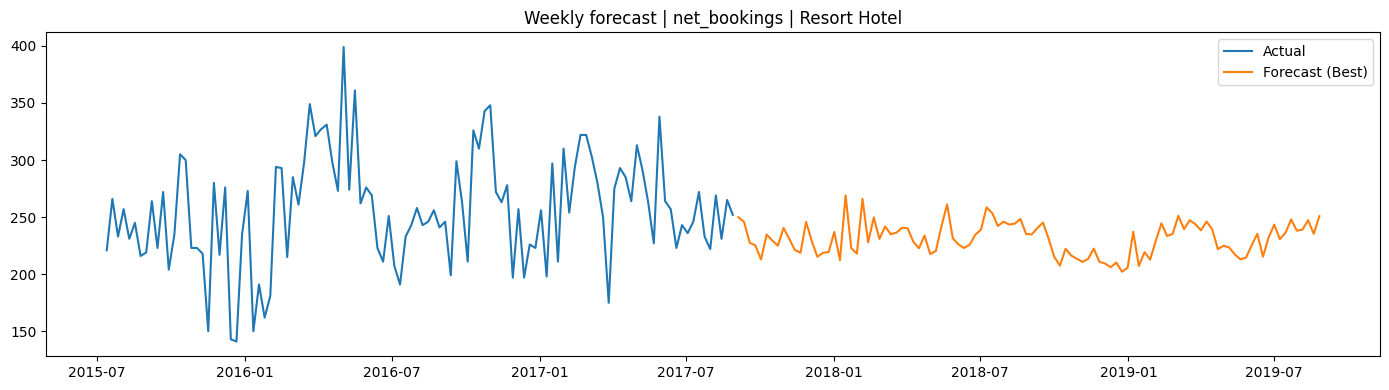

Saved: /kaggle/working/weekly_forecast_net_bookings_Resort_Hotel.png


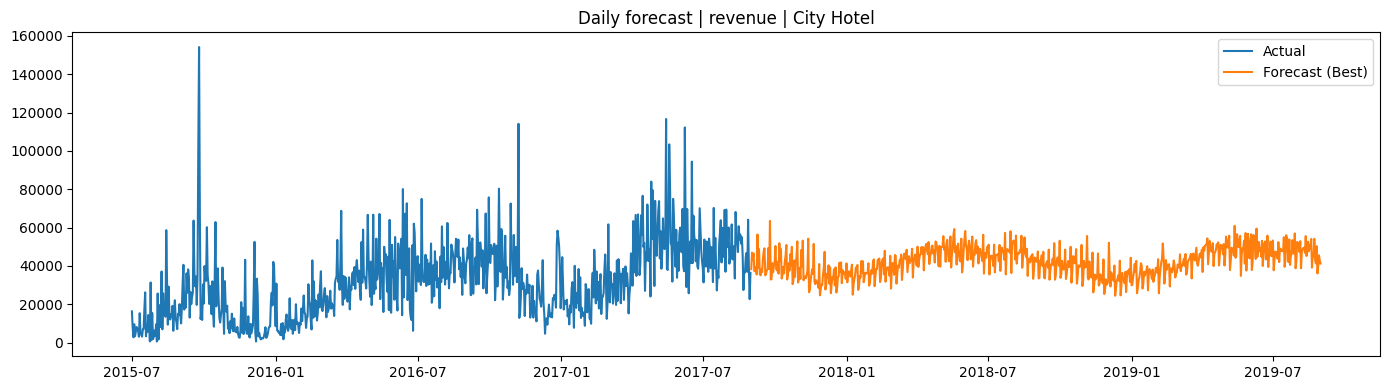

Saved: /kaggle/working/daily_forecast_revenue_City_Hotel.png


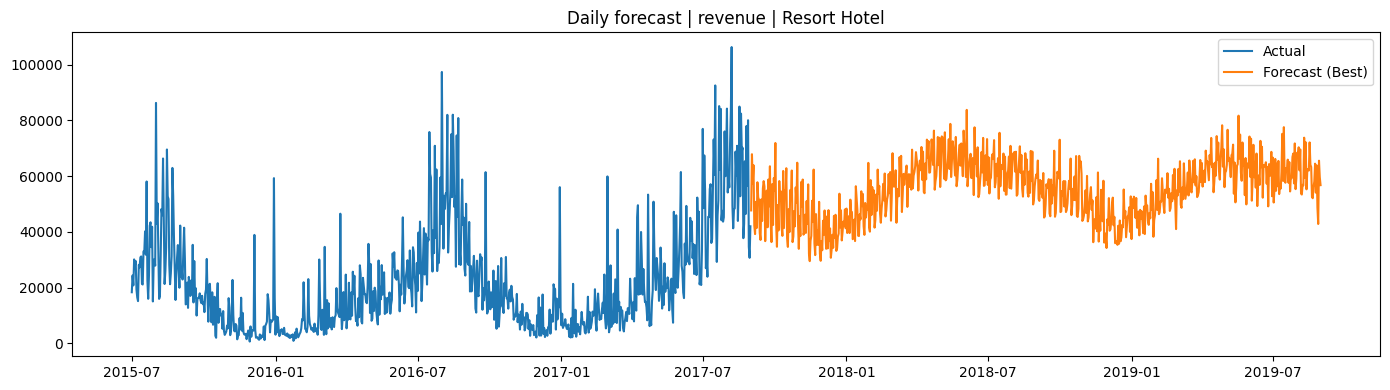

Saved: /kaggle/working/daily_forecast_revenue_Resort_Hotel.png


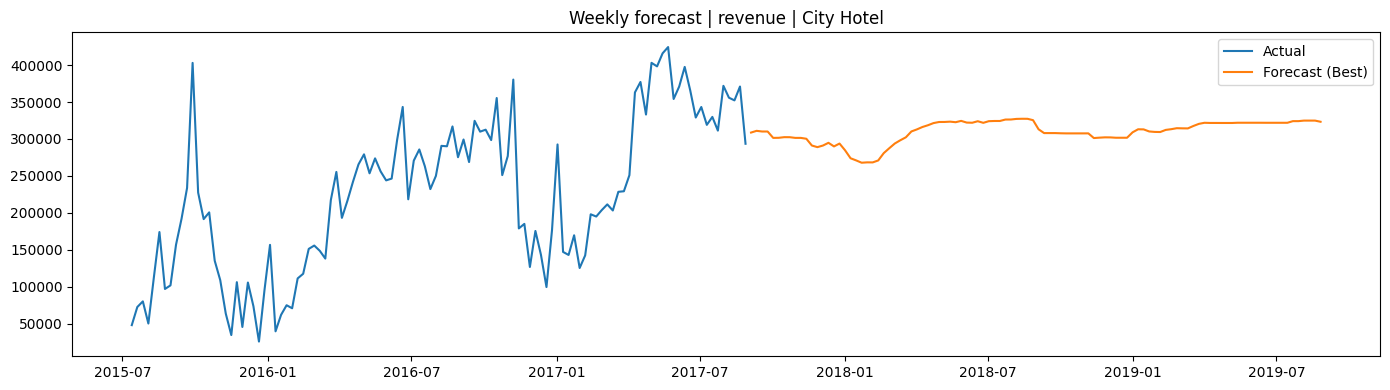

Saved: /kaggle/working/weekly_forecast_revenue_City_Hotel.png


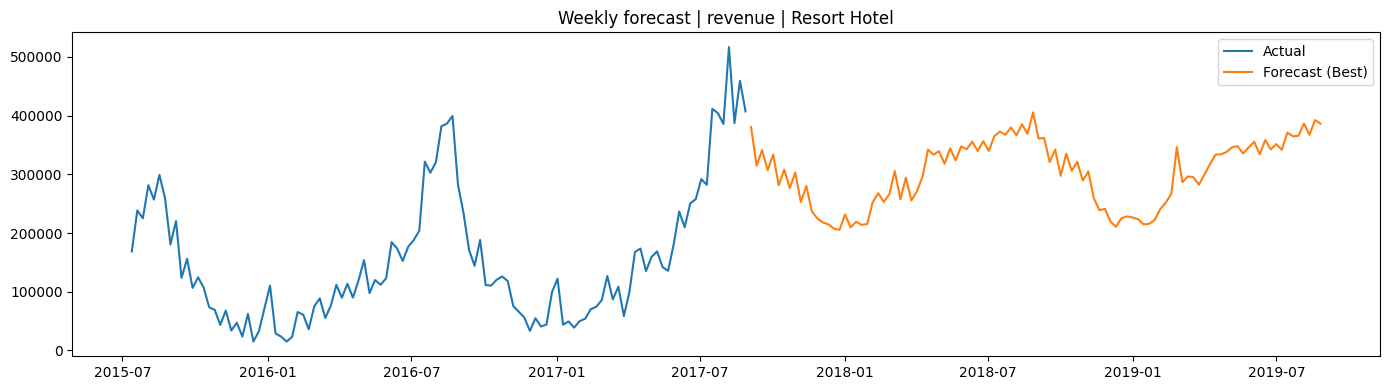

Saved: /kaggle/working/weekly_forecast_revenue_Resort_Hotel.png


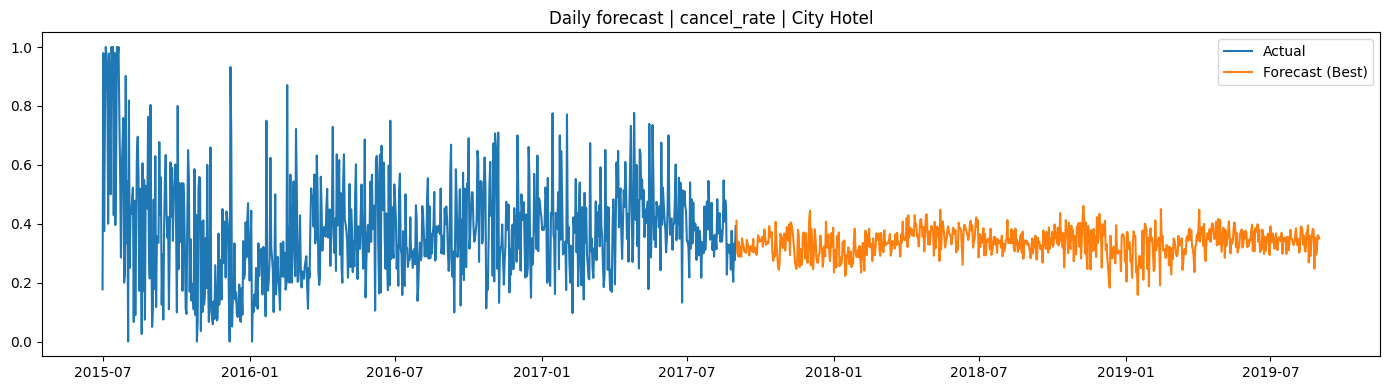

Saved: /kaggle/working/daily_forecast_cancel_rate_City_Hotel.png


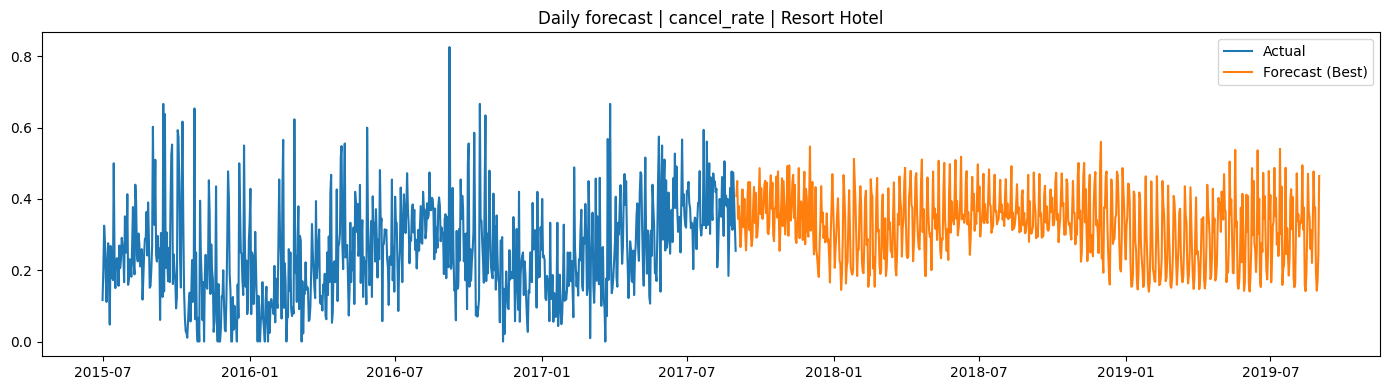

Saved: /kaggle/working/daily_forecast_cancel_rate_Resort_Hotel.png


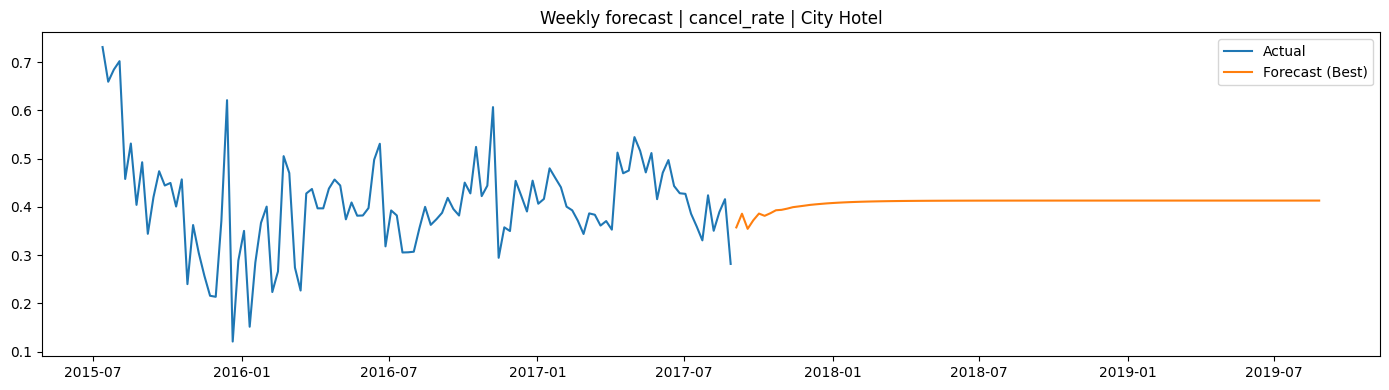

Saved: /kaggle/working/weekly_forecast_cancel_rate_City_Hotel.png


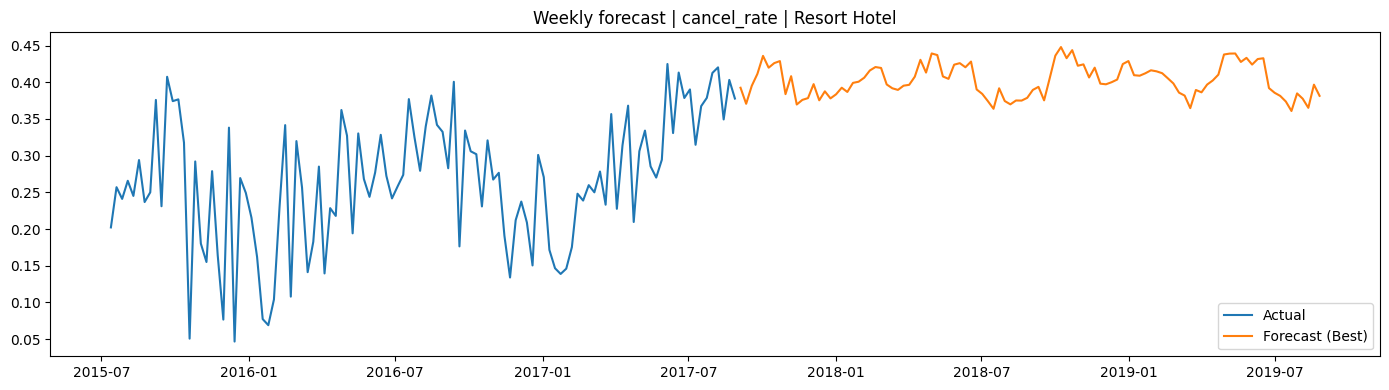

Saved: /kaggle/working/weekly_forecast_cancel_rate_Resort_Hotel.png


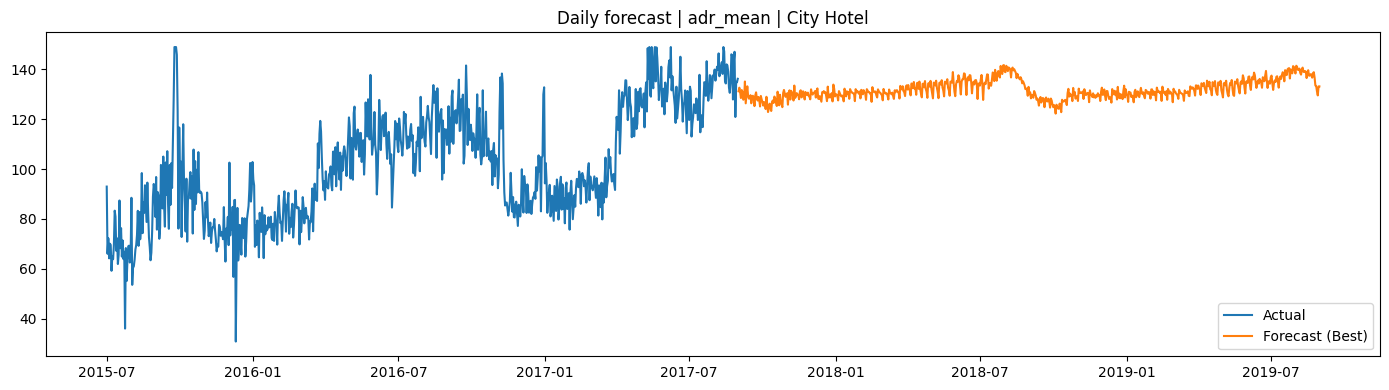

Saved: /kaggle/working/daily_forecast_adr_mean_City_Hotel.png


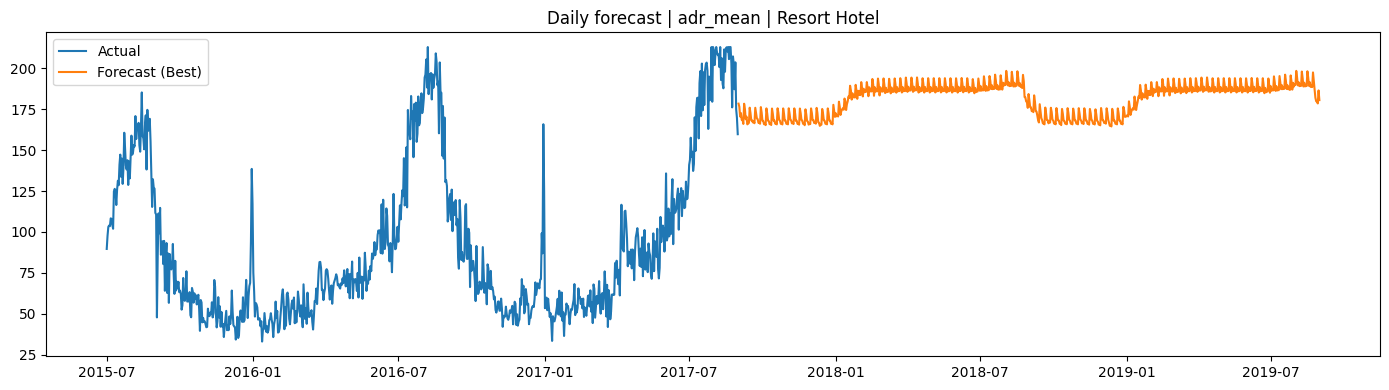

Saved: /kaggle/working/daily_forecast_adr_mean_Resort_Hotel.png


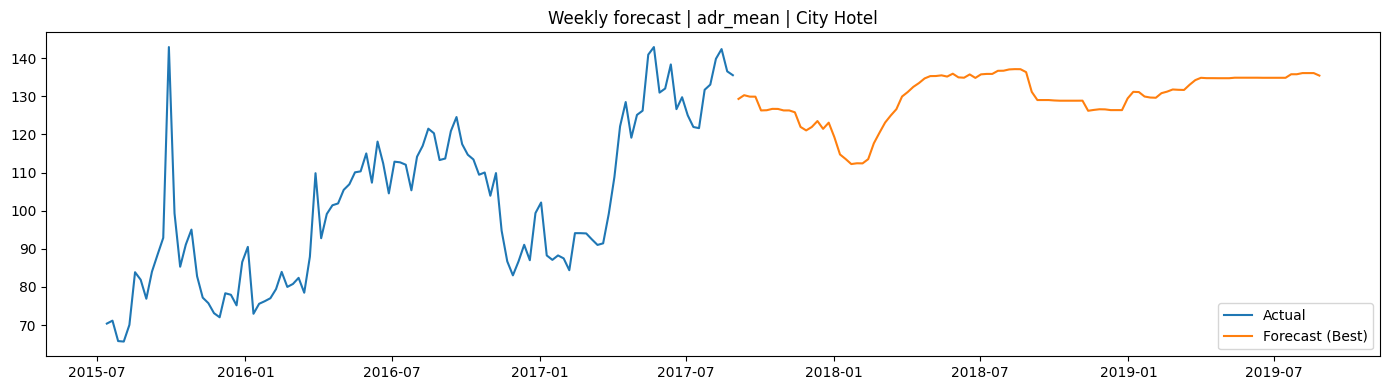

Saved: /kaggle/working/weekly_forecast_adr_mean_City_Hotel.png


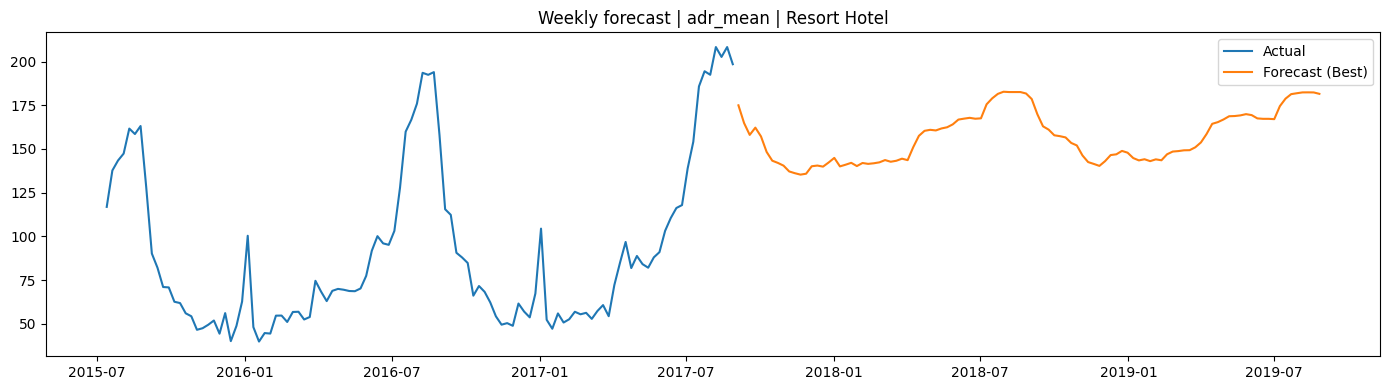

Saved: /kaggle/working/weekly_forecast_adr_mean_Resort_Hotel.png
Saved outputs in: /kaggle/working


In [13]:
def fit_and_forecast(panel, target, kind, freq, horizon, season_length, lags, date_features, cap_map=None):
    ydf = panel[["unique_id","ds",target]].rename(columns={target:"y"}).copy()
    ydf["ds"] = pd.to_datetime(ydf["ds"])
    ydf = ydf.sort_values(["unique_id","ds"]).reset_index(drop=True)

    y_sf = ydf.copy()
    y_ml = ydf.copy()
    inv_fn = None

    if kind == "rate":
        y_sf["y"] = logit(y_sf["y"])
        y_ml["y"] = logit(y_ml["y"])
        inv_fn = inv_logit

    if kind == "value":
        y_sf["y"] = log1p_clip(y_sf["y"])
        y_ml["y"] = log1p_clip(y_ml["y"])
        inv_fn = inv_log1p

    sf = StatsForecast(models=build_models(season_length), freq=freq, n_jobs=-1)
    sf.fit(y_sf)
    fc_sf = standardize_sf_cols(sf.predict(h=horizon))

    fcst = MLForecast(
        models=[lgbm_for_target(kind)],
        freq=freq,
        lags=lags,
        date_features=date_features
    )
    fcst.fit(y_ml, dropna=False)
    fc_ml = fcst.predict(h=horizon).rename(columns={"LGBMRegressor":"LGBM_t"})

    if kind in ["rate","value"]:
        fc_ml["LGBM"] = inv_fn(fc_ml["LGBM_t"].values)
        fc_ml = fc_ml.drop(columns=["LGBM_t"])
        for c in ["ETS","AutoARIMA","SeasonalNaive"]:
            if c in fc_sf.columns:
                fc_sf[c] = inv_fn(fc_sf[c].values)
    else:
        fc_ml = fc_ml.rename(columns={"LGBM_t":"LGBM"})

    fc = fc_sf.merge(fc_ml, on=["unique_id","ds"], how="inner")

    if kind == "count":
        for c in ["ETS","AutoARIMA","SeasonalNaive","LGBM"]:
            if c in fc.columns:
                fc[c] = fc[c].clip(lower=0)

    if kind == "rate":
        for c in ["ETS","AutoARIMA","SeasonalNaive","LGBM"]:
            if c in fc.columns:
                fc[c] = np.clip(fc[c], 0, 1)

    if kind == "value":
        if cap_map is not None:
            for c in ["ETS","AutoARIMA","SeasonalNaive","LGBM"]:
                if c in fc.columns:
                    fc[c] = fc.apply(lambda r: min(r[c], cap_map.get(r["unique_id"], r[c])), axis=1)
        for c in ["ETS","AutoARIMA","SeasonalNaive","LGBM"]:
            if c in fc.columns:
                fc[c] = fc[c].clip(lower=0)

    base_candidates = [c for c in ["ETS","AutoARIMA","SeasonalNaive"] if c in fc.columns]

    alpha_map = {}
    base_map = {}

    for uid in fc["unique_id"].unique():
        alpha_map[uid] = 0.5
        base_map[uid] = base_candidates[0] if base_candidates else "AutoARIMA"

    fc["alpha"] = fc["unique_id"].map(alpha_map)
    fc["hybrid_base"] = fc["unique_id"].map(base_map)

    base_vals = np.zeros(len(fc))
    for b in base_candidates:
        base_vals = np.where(fc["hybrid_base"].eq(b), fc[b].values, base_vals)
    fc["Hybrid"] = fc["alpha"].values * base_vals + (1 - fc["alpha"].values) * fc["LGBM"].values

    fc["freq"] = freq
    fc["target"] = target
    return fc, sf, fcst

DAILY_H = 365 * 2
WEEKLY_H = 104

daily_future_all = []
weekly_future_all = []
trained_models = {}

for t, meta in base_targets.items():
    fc, sf_obj, ml_obj = fit_and_forecast(
        daily, t, meta["kind"], freq="D", horizon=DAILY_H,
        season_length=7, lags=DAILY_CFG["lags"], date_features=DAILY_CFG["date_features"],
        cap_map=adr_cap_daily if t=="adr_mean" else None
    )
    daily_future_all.append(fc)
    trained_models[("D", t)] = {"sf": sf_obj, "ml": ml_obj}

for t, meta in base_targets.items():
    fc, sf_obj, ml_obj = fit_and_forecast(
        weekly, t, meta["kind"], freq="W-MON", horizon=WEEKLY_H,
        season_length=52, lags=WEEKLY_CFG["lags"], date_features=WEEKLY_CFG["date_features"],
        cap_map=adr_cap_weekly if t=="adr_mean" else None
    )
    weekly_future_all.append(fc)
    trained_models[("W-MON", t)] = {"sf": sf_obj, "ml": ml_obj}

daily_future = pd.concat(daily_future_all, ignore_index=True)
weekly_future = pd.concat(weekly_future_all, ignore_index=True)

daily_future.to_csv(f"{OUTDIR}/daily_future_all_models_base_targets.csv", index=False)
weekly_future.to_csv(f"{OUTDIR}/weekly_future_all_models_base_targets.csv", index=False)

best_daily = best_models[best_models["freq"]=="D"]
best_weekly = best_models[best_models["freq"]=="W-MON"]

daily_future_best_base = apply_best(daily_future, best_daily)
weekly_future_best_base = apply_best(weekly_future, best_weekly)

daily_fw = daily_future_best_base.pivot_table(index=["freq","unique_id","ds"], columns="target", values="yhat_best", aggfunc="first")
weekly_fw = weekly_future_best_base.pivot_table(index=["freq","unique_id","ds"], columns="target", values="yhat_best", aggfunc="first")

daily_fw["canceled_bookings"] = daily_fw["bookings"] * daily_fw["cancel_rate"]
daily_fw["net_bookings"] = daily_fw["bookings"] * (1 - daily_fw["cancel_rate"])
daily_fw["revenue"] = daily_fw["room_nights"] * daily_fw["adr_mean"]

weekly_fw["canceled_bookings"] = weekly_fw["bookings"] * weekly_fw["cancel_rate"]
weekly_fw["net_bookings"] = weekly_fw["bookings"] * (1 - weekly_fw["cancel_rate"])
weekly_fw["revenue"] = weekly_fw["room_nights"] * weekly_fw["adr_mean"]

daily_future_best_all = daily_fw.reset_index().melt(id_vars=["freq","unique_id","ds"], var_name="target", value_name="yhat_best")
weekly_future_best_all = weekly_fw.reset_index().melt(id_vars=["freq","unique_id","ds"], var_name="target", value_name="yhat_best")

daily_future_best_all.to_csv(f"{OUTDIR}/daily_future_forecast_best_all_targets.csv", index=False)
weekly_future_best_all.to_csv(f"{OUTDIR}/weekly_future_forecast_best_all_targets.csv", index=False)

def plot_future(panel_hist, future_best_long, target, freq_label, outname_prefix):
    hist = panel_hist[["unique_id","ds",target]].rename(columns={target:"y"}).copy()
    fut = future_best_long[future_best_long["target"]==target].copy()

    for uid in hist["unique_id"].unique():
        h = hist[hist["unique_id"]==uid].sort_values("ds")
        f = fut[fut["unique_id"]==uid].sort_values("ds")

        plt.figure(figsize=(14,4))
        plt.plot(h["ds"], h["y"], label="Actual")
        plt.plot(f["ds"], f["yhat_best"], label="Forecast (Best)")
        plt.title(f"{freq_label} forecast | {target} | {uid}")
        plt.legend()
        plt.tight_layout()

        p = f"{OUTDIR}/{outname_prefix}_{target}_{uid.replace(' ','_')}.png"
        plt.savefig(p, dpi=150)
        plt.show()
        print("Saved:", p)

for t in ["bookings","net_bookings","revenue","cancel_rate","adr_mean"]:
    plot_future(daily, daily_future_best_all, t, "Daily", "daily_forecast")
    plot_future(weekly, weekly_future_best_all, t, "Weekly", "weekly_forecast")

joblib.dump(best_models, f"{OUTDIR}/best_models_base_targets.joblib")
joblib.dump(trained_models, f"{OUTDIR}/trained_models_all_targets.joblib")

!pip freeze > /kaggle/working/requirements.txt

print("Saved outputs in:", OUTDIR)


## Narrative

In [14]:
import numpy as np
import pandas as pd

def _safe_div(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    out = np.full_like(a, np.nan, dtype=float)
    mask = (b != 0) & np.isfinite(a) & np.isfinite(b)
    out[mask] = a[mask] / b[mask]
    return out

def summarize_backtest_detailed(bt_best, freq_label):
    df = bt_best.copy()
    df = df.dropna(subset=["y", "yhat_best"]).copy()
    df["error"] = df["yhat_best"] - df["y"]
    df["abs_error"] = df["error"].abs()
    df["sq_error"] = df["error"]**2

    # APE + sAPE (safe)
    df["ape"] = np.where(df["y"] != 0, df["abs_error"] / np.abs(df["y"]), np.nan)
    denom = np.abs(df["y"]) + np.abs(df["yhat_best"])
    df["sape"] = np.where(denom != 0, 2 * df["abs_error"] / denom, np.nan)

    # group summaries
    out = []
    group_cols = ["target", "unique_id"]
    for (t, uid), g in df.groupby(group_cols):
        n = len(g)
        actual_sum = g["y"].sum()
        forecast_sum = g["yhat_best"].sum()

        mae = g["abs_error"].mean()
        rmse = np.sqrt(g["sq_error"].mean())
        wape = (g["abs_error"].sum() / actual_sum) if actual_sum != 0 else np.nan
        mape = g["ape"].mean()
        smape = g["sape"].mean()

        bias = g["error"].mean()
        bias_pct = (g["error"].sum() / actual_sum) if actual_sum != 0 else np.nan

        med_ae = g["abs_error"].median()
        p90_ae = np.nanpercentile(g["abs_error"], 90)
        p95_ae = np.nanpercentile(g["abs_error"], 95)

        over_rate = (g["error"] > 0).mean()
        under_rate = (g["error"] < 0).mean()

        vol_err = forecast_sum - actual_sum
        vol_err_pct = (vol_err / actual_sum) if actual_sum != 0 else np.nan

        out.append({
            "freq": freq_label,
            "target": t,
            "unique_id": uid,
            "n": n,
            "actual_sum": actual_sum,
            "forecast_sum": forecast_sum,
            "MAE": mae,
            "RMSE": rmse,
            "WAPE": wape,
            "MAPE": mape,
            "sMAPE": smape,
            "Bias": bias,
            "Bias_pct": bias_pct,
            "Median_AE": med_ae,
            "P90_AE": p90_ae,
            "P95_AE": p95_ae,
            "Over_rate": over_rate,
            "Under_rate": under_rate,
            "Volume_Error": vol_err,
            "Volume_Error_pct": vol_err_pct
        })

    out_df = pd.DataFrame(out)

    # weighted rollups (weights = actual_sum)
    w = out_df["actual_sum"].clip(lower=0)
    weighted = {
        "freq": freq_label,
        "Weighted_WAPE": np.average(out_df["WAPE"], weights=w) if w.sum() > 0 else np.nan,
        "Weighted_Bias_pct": np.average(out_df["Bias_pct"], weights=w) if w.sum() > 0 else np.nan,
        "Weighted_sMAPE": np.average(out_df["sMAPE"], weights=w) if w.sum() > 0 else np.nan,
        "Weighted_MAPE": np.average(out_df["MAPE"], weights=w) if w.sum() > 0 else np.nan,
    }
    weighted_df = pd.DataFrame([weighted])

    return out_df.sort_values(["target","unique_id"]).reset_index(drop=True), weighted_df


# ---- Build detailed stats from best backtests ----
daily_detail, daily_weighted = summarize_backtest_detailed(daily_best_hist, "D")
weekly_detail, weekly_weighted = summarize_backtest_detailed(weekly_best_hist, "W-MON")

detailed_all = pd.concat([daily_detail, weekly_detail], ignore_index=True)
weighted_all = pd.concat([daily_weighted, weekly_weighted], ignore_index=True)

OUTDIR = "/kaggle/working"
detailed_path = f"{OUTDIR}/detailed_forecast_stats_plus.csv"
weighted_path = f"{OUTDIR}/weighted_forecast_summary.csv"

detailed_all.to_csv(detailed_path, index=False)
weighted_all.to_csv(weighted_path, index=False)

print("Saved:", detailed_path)
print("Saved:", weighted_path)

display(weighted_all)
display(detailed_all.head(20))


# ---- Narrative summary (no comparisons) ----
def narrative_from_tables(detail_df, weighted_df, top_k=5):
    lines = []
    lines.append("### Forecast Performance Narrative (Backtest)\n")

    # Overall summary by frequency
    for _, r in weighted_df.iterrows():
        freq = r["freq"]
        lines.append(f"**Overall ({freq})**")
        lines.append(f"- Weighted WAPE: **{r['Weighted_WAPE']:.2%}**")
        lines.append(f"- Weighted Bias%: **{r['Weighted_Bias_pct']:.2%}**")
        lines.append(f"- Weighted sMAPE: **{r['Weighted_sMAPE']:.2%}**")
        lines.append("")

    # Best and worst by WAPE within each frequency
    for freq in detail_df["freq"].unique():
        sub = detail_df[detail_df["freq"] == freq].copy()
        sub = sub.dropna(subset=["WAPE"])
        if len(sub) == 0:
            continue

        best = sub.nsmallest(top_k, "WAPE")[["target","unique_id","WAPE","Bias_pct","MAE"]]
        worst = sub.nlargest(top_k, "WAPE")[["target","unique_id","WAPE","Bias_pct","MAE"]]

        lines.append(f"**Strongest performance ({freq})**")
        for _, r in best.iterrows():
            lines.append(
                f"- {r['target']} | {r['unique_id']}: WAPE **{r['WAPE']:.2%}**, Bias% **{r['Bias_pct']:.2%}**, MAE **{r['MAE']:.2f}**"
            )
        lines.append("")

        lines.append(f"**Most challenging segments ({freq})**")
        for _, r in worst.iterrows():
            lines.append(
                f"- {r['target']} | {r['unique_id']}: WAPE **{r['WAPE']:.2%}**, Bias% **{r['Bias_pct']:.2%}**, MAE **{r['MAE']:.2f}**"
            )
        lines.append("")

    # Bias direction
    lines.append("**Bias and volume behavior**")
    lines.append("- Positive Bias% indicates systematic over-forecasting; negative Bias% indicates under-forecasting.")
    lines.append("- Volume_Error_pct indicates whether total forecasted volume over the evaluation period is above or below actual volume.")
    lines.append("")

    return "\n".join(lines)

narrative_md = narrative_from_tables(detailed_all, weighted_all, top_k=5)
print(narrative_md)

with open(f"{OUTDIR}/forecast_narrative.md", "w") as f:
    f.write(narrative_md)

print("Saved:", f"{OUTDIR}/forecast_narrative.md")


Saved: /kaggle/working/detailed_forecast_stats_plus.csv
Saved: /kaggle/working/weighted_forecast_summary.csv


freq  Weighted_WAPE  Weighted_Bias_pct  Weighted_sMAPE  Weighted_MAPE
0      D       0.286849          -0.073172        0.324336       0.366013
1  W-MON       0.220524          -0.151842        0.240651       0.214090

freq             target     unique_id    n    actual_sum  forecast_sum           MAE          RMSE      WAPE      MAPE     sMAPE         Bias  Bias_pct    Median_AE        P90_AE        P95_AE  Over_rate  \
0       D           adr_mean    City Hotel  300  3.368455e+04  3.251625e+04      9.420758     12.143352  0.083903  0.084312  0.086627    -3.894327 -0.034684     7.812942     20.089800     22.720209   0.380000   
1       D           adr_mean  Resort Hotel  300  2.888875e+04  2.715175e+04     12.975363     18.892936  0.134745  0.137494  0.141618    -5.790006 -0.060127     8.936257     30.051177     44.784968   0.413333   
2       D       adults_total    City Hotel  300  6.093700e+04  6.063341e+04     55.517397     74.864409  0.273319  0.315067  0.282913    -1.011968 -0.004982    43.710349    118.724438    162.783421   0.580000   
3       D       adults_total  Resort Hotel  300  2.896100e+04  2.943335e+04     28.116974     38.824221  0.291257  0.358060  0.296339     1.574516  0.016310    21.224532     59.980844     73.706923   0.590000   
4       D           bookings    City Hotel  300  3.250200e+04  3.239636e+04     30.514130     41.997864  0.281652  0.321212  0.287740    -0.352149 -0.003250    20.935166     64.971111     88.917118   0.593333   
5       D           bookings  Resort Hotel  300  1.567800e+04  1.589335e+04     14.957710     20.342085  0.286217  0.339077  0.286741     0.717842  0.013736    11.163607     30.955136     38.148992   0.553333   
6       D        cancel_rate    City Hotel  300  1.176678e+02  1.180402e+02      0.105335      0.135925  0.268557  0.319392  0.274570     0.001241  0.003165     0.084865      0.222151      0.293051   0.550000   
7       D        cancel_rate  Resort Hotel  300  8.235221e+01  7.023108e+01      0.091181      0.119213  0.332163  0.470892  0.389298    -0.040404 -0.147187     0.070474      0.198711      0.239328   0.416667   
8       D  canceled_bookings    City Hotel  300  1.375700e+04  1.306331e+04     21.334399     32.227727  0.465241  0.640120  0.465982    -2.312310 -0.050425    15.472617     44.185690     64.478796   0.620000   
9       D  canceled_bookings  Resort Hotel  300  4.597000e+03  3.808296e+03      6.876348      9.944988  0.448750  0.655485  0.496115    -2.629012 -0.171569     4.633428     15.402719     22.442618   0.496667   
10      D       guests_total    City Hotel  300  6.450200e+04  6.555073e+04     61.221644     79.942051  0.284743  0.346578  0.297826     3.495775  0.016259    48.454545    129.622011    154.173606   0.593333   
11      D       guests_total  Resort Hotel  300  3.154600e+04  3.153452e+04     32.624296     44.602450  0.310255  0.383077  0.318107    -0.038282 -0.000364    24.003572     67.770891     85.380054   0.580000   
12      D       net_bookings    City Hotel  300  1.874500e+04  1.933305e+04     16.131909     20.589941  0.258179  0.297197  0.262260     1.960161  0.031371    12.920616     32.628794     38.398387   0.586667   
13      D       net_bookings  Resort Hotel  300  1.108100e+04  1.208506e+04     11.366905     15.242150  0.307740  0.381572  0.300733     3.346854  0.090611     8.610662     24.354076     29.689561   0.640000   
14      D            revenue    City Hotel  300  1.169244e+07  1.077801e+07  10550.054092  15100.700482  0.270689  0.308401  0.290757 -3048.116942 -0.078207  7755.906158  22208.860740  30136.109006   0.500000   
15      D            revenue  Resort Hotel  300  7.358079e+06  6.847410e+06   7689.825247  11535.406405  0.313526  0.460217  0.380690 -1702.229763 -0.069402  4643.812050  18517.603475  23621.917716   0.543333   
16      D        room_nights    City Hotel  300  1.015700e+05  9.678449e+04     89.879023    123.502564  0.265469  0.300497  0.275980   -15.951716 -0.047115    68.904310    189.103459    244.813420   0.516667   
17      D        room_nights  Resort Hotel  300  6.828400e+04  6.801947e+04     76.733940    115.576969  0.337124  0.441354  0.351608    -0.881765 -0.003874    58.286050    151.844895    19

### Forecast Performance Narrative (Backtest)

**Overall (D)**
- Weighted WAPE: **28.68%**
- Weighted Bias%: **-7.32%**
- Weighted sMAPE: **32.43%**

**Overall (W-MON)**
- Weighted WAPE: **22.05%**
- Weighted Bias%: **-15.18%**
- Weighted sMAPE: **24.07%**

**Strongest performance (D)**
- adr_mean | City Hotel: WAPE **8.39%**, Bias% **-3.47%**, MAE **9.42**
- adr_mean | Resort Hotel: WAPE **13.47%**, Bias% **-6.01%**, MAE **12.98**
- net_bookings | City Hotel: WAPE **25.82%**, Bias% **3.14%**, MAE **16.13**
- room_nights | City Hotel: WAPE **26.55%**, Bias% **-4.71%**, MAE **89.88**
- cancel_rate | City Hotel: WAPE **26.86%**, Bias% **0.32%**, MAE **0.11**

**Most challenging segments (D)**
- canceled_bookings | City Hotel: WAPE **46.52%**, Bias% **-5.04%**, MAE **21.33**
- canceled_bookings | Resort Hotel: WAPE **44.88%**, Bias% **-17.16%**, MAE **6.88**
- room_nights | Resort Hotel: WAPE **33.71%**, Bias% **-0.39%**, MAE **76.73**
- cancel_rate | Resort Hotel: WAPE **33.22%**, Bias% 

### What the workflow achieves

By design, the pipeline delivers:

- Clean, validated daily and weekly time series built from booking-level records.
- Multi-model forecasting using both:
  - statistical models (ETS/ARIMA/Seasonal Naive), and
  - machine learning (LightGBM via MLForecast).
- Hybrid blending to combine seasonal stability with nonlinear predictive power.
- Rolling backtests that realistically represent how the model will perform in production.
- Two-year forward forecasts exported in structured CSV format.
- Full transparency through saved predictions, saved metrics, and saved diagnostic plots.

### Why the workflow is production-ready

This workflow is structured for operational reuse:

1. **Reproducibility**  
   The entire process—from raw data ingestion to forecasting outputs—is deterministic and produces consistent artifacts (CSVs and plots) that can be versioned.

2. **Frequency-specific forecasting**  
   Daily and weekly forecasts are treated as separate products with consistent time indexing and aggregation. Weekly series alignment (e.g., W-MON) prevents misinterpretation and improves comparability.

3. **Model governance**  
   Best-model selection is performed per target and hotel type using repeatable backtest criteria. This supports segment-level monitoring, targeted improvements, and explainable model decisions.

4. **Diagnostics that support trust**  
   Accuracy is complemented with bias and distribution diagnostics:
   - error histograms show skew and tail behavior,
   - bias measures show systematic under/over forecasting,
   - backtest overlays help validate tracking against real demand patterns.

5. **Operational constraints**  
   Forecasts are constrained where appropriate (e.g., non-negativity), which ensures outputs remain realistic for demand and revenue-like metrics.

### How to use the final outputs

The notebook produces artifacts designed for both analytics and operational planning:

- **Backtest CSVs**: performance reporting and validation, audit-ready evaluation.
- **Future forecast CSVs**: planning dashboards, BI pipelines, automated workflows.
- **Forecast plots**: communication-ready visual summaries for stakeholders.
- **Detailed forecast stats CSV**: monitoring and alerting, KPI-based governance.

### Recommended operational next steps

For ongoing usage beyond Kaggle:

- Retrain periodically (e.g., monthly or quarterly) to incorporate new patterns.
- Track WAPE and Bias% over time to detect drift and degradation.
- Add external drivers (holidays, promotions, events) if available for further uplift.
- Consider reconciliation policies for strict consistency among linked targets (e.g., bookings vs cancellations vs net bookings).

This notebook provides a robust forecasting foundation: **validated data → rolling backtests → best-model selection → future forecasting → exportable artifacts**, ready for integration into decision-making and production analytics environments.